### TFG AÑO- Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de año a año (252 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testAño.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testAño.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testAño.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testAño.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



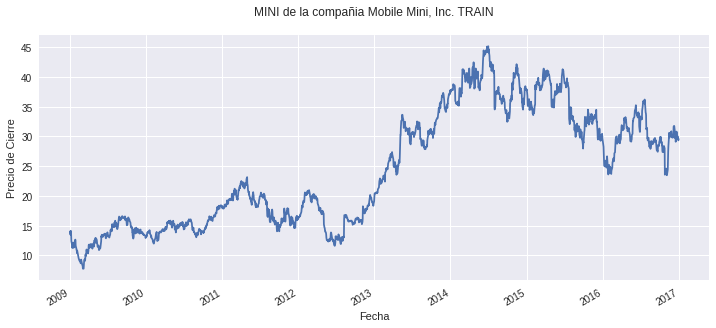

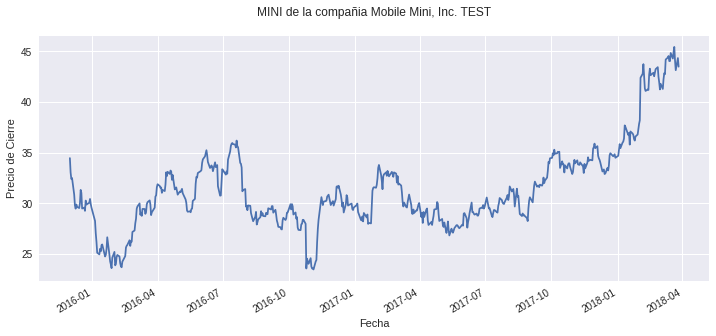

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 4
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [7]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo MINI de la compañia Mobile Mini, Inc.


In [9]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

# Creacion de la red neural LSTM

In [17]:
model42 = Sequential()
model42.add(LSTM(4, input_shape=(252,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 4)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 15s 401ms/step - loss: 777.0958 - porcentaje_margen: 0.0000e+00 - val_loss: 759.3543 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 14s 377ms/step - loss: 771.2635 - porcentaje_margen: 0.0000e+00 - val_loss: 752.0617 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==================

37/37 [==============================] - 12s 324ms/step - loss: 341.8832 - porcentaje_margen: 0.0000e+00 - val_loss: 332.3181 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 12s 331ms/step - loss: 338.7981 - porcentaje_margen: 0.0000e+00 - val_loss: 329.3203 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 12s 327ms/step - loss: 335.7525 - porcentaje_margen: 0.0000e+00 - val_loss: 326.3338 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 12s 326ms/step - loss: 332.7200 - porcentaje_margen: 0.0000e+00 - val_loss: 323.3660 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 12s 324ms/step - loss: 329.6978 - porcentaje_margen: 0.0000e+00 - val_loss: 320.4530 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 12s 325ms/step - loss: 326.7045 - porcentaje_margen: 0.0000e+00 - val_loss: 317

37/37 [==============================] - 12s 321ms/step - loss: 139.8705 - porcentaje_margen: 0.0811 - val_loss: 137.2577 - val_porcentaje_margen: 0.0839
Epoch 186/1500
37/37 [==============================] - 12s 332ms/step - loss: 138.6802 - porcentaje_margen: 0.0828 - val_loss: 136.1157 - val_porcentaje_margen: 0.0839
Epoch 187/1500
37/37 [==============================] - 12s 315ms/step - loss: 137.4892 - porcentaje_margen: 0.0811 - val_loss: 135.0047 - val_porcentaje_margen: 0.0839
Epoch 188/1500
37/37 [==============================] - 12s 322ms/step - loss: 136.3293 - porcentaje_margen: 0.0895 - val_loss: 133.8987 - val_porcentaje_margen: 0.0806
Epoch 189/1500
37/37 [==============================] - 12s 319ms/step - loss: 135.1827 - porcentaje_margen: 0.0794 - val_loss: 132.8192 - val_porcentaje_margen: 0.0773
Epoch 190/1500
37/37 [==============================] - 12s 326ms/step - loss: 134.0534 - porcentaje_margen: 0.0785 - val_loss: 131.7461 - val_porcentaje_margen: 0.0773
E

37/37 [==============================] - 13s 341ms/step - loss: 50.8918 - porcentaje_margen: 0.2221 - val_loss: 49.1818 - val_porcentaje_margen: 0.2520
Epoch 283/1500
37/37 [==============================] - 12s 332ms/step - loss: 49.7331 - porcentaje_margen: 0.2348 - val_loss: 48.0482 - val_porcentaje_margen: 0.2553
Epoch 284/1500
37/37 [==============================] - 12s 334ms/step - loss: 48.6429 - porcentaje_margen: 0.2348 - val_loss: 46.9690 - val_porcentaje_margen: 0.2421
Epoch 285/1500
37/37 [==============================] - 12s 336ms/step - loss: 47.5890 - porcentaje_margen: 0.2323 - val_loss: 45.9537 - val_porcentaje_margen: 0.2586
Epoch 286/1500
37/37 [==============================] - 13s 339ms/step - loss: 46.5761 - porcentaje_margen: 0.2348 - val_loss: 45.0545 - val_porcentaje_margen: 0.2569
Epoch 287/1500
37/37 [==============================] - 13s 343ms/step - loss: 45.5781 - porcentaje_margen: 0.2424 - val_loss: 44.0520 - val_porcentaje_margen: 0.2372
Epoch 288/150

37/37 [==============================] - 12s 319ms/step - loss: 8.8141 - porcentaje_margen: 0.5431 - val_loss: 8.3053 - val_porcentaje_margen: 0.5437
Epoch 381/1500
37/37 [==============================] - 12s 320ms/step - loss: 8.6364 - porcentaje_margen: 0.5498 - val_loss: 8.1004 - val_porcentaje_margen: 0.5339
Epoch 382/1500
37/37 [==============================] - 12s 320ms/step - loss: 8.4731 - porcentaje_margen: 0.5490 - val_loss: 7.9994 - val_porcentaje_margen: 0.5487
Epoch 383/1500
37/37 [==============================] - 12s 316ms/step - loss: 8.3631 - porcentaje_margen: 0.5355 - val_loss: 7.7758 - val_porcentaje_margen: 0.5487
Epoch 384/1500
37/37 [==============================] - 12s 319ms/step - loss: 8.1801 - porcentaje_margen: 0.5515 - val_loss: 7.6311 - val_porcentaje_margen: 0.5503
Epoch 385/1500
37/37 [==============================] - 12s 320ms/step - loss: 8.0577 - porcentaje_margen: 0.5380 - val_loss: 7.5307 - val_porcentaje_margen: 0.5602
Epoch 386/1500
37/37 [===

Epoch 430/1500
37/37 [==============================] - 11s 308ms/step - loss: 3.7140 - porcentaje_margen: 0.6301 - val_loss: 3.5006 - val_porcentaje_margen: 0.6457
Epoch 431/1500
37/37 [==============================] - 12s 312ms/step - loss: 3.6741 - porcentaje_margen: 0.6351 - val_loss: 3.4395 - val_porcentaje_margen: 0.6424
Epoch 432/1500
37/37 [==============================] - 11s 308ms/step - loss: 3.6038 - porcentaje_margen: 0.6427 - val_loss: 3.4078 - val_porcentaje_margen: 0.6359
Epoch 433/1500
37/37 [==============================] - 12s 312ms/step - loss: 3.5550 - porcentaje_margen: 0.6394 - val_loss: 3.4358 - val_porcentaje_margen: 0.6414
Epoch 434/1500
37/37 [==============================] - 12s 314ms/step - loss: 3.4969 - porcentaje_margen: 0.6368 - val_loss: 3.3415 - val_porcentaje_margen: 0.6628
Epoch 435/1500
37/37 [==============================] - 12s 311ms/step - loss: 3.4555 - porcentaje_margen: 0.6529 - val_loss: 3.2500 - val_porcentaje_margen: 0.6474
Epoch 436/

Epoch 480/1500
37/37 [==============================] - 12s 314ms/step - loss: 2.0004 - porcentaje_margen: 0.7382 - val_loss: 1.9711 - val_porcentaje_margen: 0.7296
Epoch 481/1500
37/37 [==============================] - 11s 308ms/step - loss: 1.9756 - porcentaje_margen: 0.7517 - val_loss: 1.8986 - val_porcentaje_margen: 0.7339
Epoch 482/1500
37/37 [==============================] - 12s 312ms/step - loss: 2.0616 - porcentaje_margen: 0.7289 - val_loss: 2.0623 - val_porcentaje_margen: 0.6934
Epoch 483/1500
37/37 [==============================] - 11s 301ms/step - loss: 1.9623 - porcentaje_margen: 0.7576 - val_loss: 1.8881 - val_porcentaje_margen: 0.7395
Epoch 484/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.9368 - porcentaje_margen: 0.7618 - val_loss: 1.8667 - val_porcentaje_margen: 0.7329
Epoch 485/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.9075 - porcentaje_margen: 0.7534 - val_loss: 1.8218 - val_porcentaje_margen: 0.7355
Epoch 486/

Epoch 530/1500
37/37 [==============================] - 12s 317ms/step - loss: 1.5026 - porcentaje_margen: 0.7914 - val_loss: 1.3530 - val_porcentaje_margen: 0.7651
Epoch 531/1500
37/37 [==============================] - 12s 316ms/step - loss: 1.4778 - porcentaje_margen: 0.7922 - val_loss: 1.3849 - val_porcentaje_margen: 0.7569
Epoch 532/1500
37/37 [==============================] - 12s 311ms/step - loss: 1.4503 - porcentaje_margen: 0.7990 - val_loss: 1.3810 - val_porcentaje_margen: 0.7586
Epoch 533/1500
37/37 [==============================] - 12s 311ms/step - loss: 1.4567 - porcentaje_margen: 0.7922 - val_loss: 1.3373 - val_porcentaje_margen: 0.7750
Epoch 534/1500
37/37 [==============================] - 11s 311ms/step - loss: 1.4367 - porcentaje_margen: 0.7931 - val_loss: 1.3543 - val_porcentaje_margen: 0.7740
Epoch 535/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.4318 - porcentaje_margen: 0.7829 - val_loss: 1.3297 - val_porcentaje_margen: 0.7651
Epoch 536/

Epoch 580/1500
37/37 [==============================] - 11s 310ms/step - loss: 1.2702 - porcentaje_margen: 0.8184 - val_loss: 1.1981 - val_porcentaje_margen: 0.7799
Epoch 581/1500
37/37 [==============================] - 11s 303ms/step - loss: 1.2824 - porcentaje_margen: 0.8015 - val_loss: 1.2002 - val_porcentaje_margen: 0.7882
Epoch 582/1500
37/37 [==============================] - 12s 315ms/step - loss: 1.2994 - porcentaje_margen: 0.8007 - val_loss: 1.2873 - val_porcentaje_margen: 0.7717
Epoch 583/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.3080 - porcentaje_margen: 0.7948 - val_loss: 1.2770 - val_porcentaje_margen: 0.7668
Epoch 584/1500
37/37 [==============================] - 11s 308ms/step - loss: 1.2734 - porcentaje_margen: 0.8142 - val_loss: 1.1917 - val_porcentaje_margen: 0.7783
Epoch 585/1500
37/37 [==============================] - 11s 305ms/step - loss: 1.2730 - porcentaje_margen: 0.8032 - val_loss: 1.1975 - val_porcentaje_margen: 0.7750
Epoch 586/

Epoch 630/1500
37/37 [==============================] - 12s 314ms/step - loss: 1.1945 - porcentaje_margen: 0.8252 - val_loss: 1.1214 - val_porcentaje_margen: 0.7947
Epoch 631/1500
37/37 [==============================] - 11s 305ms/step - loss: 1.1763 - porcentaje_margen: 0.8133 - val_loss: 1.0851 - val_porcentaje_margen: 0.7997
Epoch 632/1500
37/37 [==============================] - 12s 314ms/step - loss: 1.1547 - porcentaje_margen: 0.8235 - val_loss: 1.1756 - val_porcentaje_margen: 0.7888
Epoch 633/1500
37/37 [==============================] - 12s 311ms/step - loss: 1.1770 - porcentaje_margen: 0.8176 - val_loss: 1.0873 - val_porcentaje_margen: 0.7947
Epoch 634/1500
37/37 [==============================] - 12s 311ms/step - loss: 1.1391 - porcentaje_margen: 0.8311 - val_loss: 1.1033 - val_porcentaje_margen: 0.7898
Epoch 635/1500
37/37 [==============================] - 11s 310ms/step - loss: 1.1602 - porcentaje_margen: 0.8277 - val_loss: 1.0791 - val_porcentaje_margen: 0.8030
Epoch 636/

Epoch 680/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.0808 - porcentaje_margen: 0.8378 - val_loss: 1.2135 - val_porcentaje_margen: 0.7997
Epoch 681/1500
37/37 [==============================] - 11s 311ms/step - loss: 1.0736 - porcentaje_margen: 0.8412 - val_loss: 1.0698 - val_porcentaje_margen: 0.8095
Epoch 682/1500
37/37 [==============================] - 12s 311ms/step - loss: 1.0555 - porcentaje_margen: 0.8404 - val_loss: 1.0386 - val_porcentaje_margen: 0.8079
Epoch 683/1500
37/37 [==============================] - 12s 312ms/step - loss: 1.0917 - porcentaje_margen: 0.8353 - val_loss: 1.0741 - val_porcentaje_margen: 0.8095
Epoch 684/1500
37/37 [==============================] - 12s 314ms/step - loss: 1.0719 - porcentaje_margen: 0.8421 - val_loss: 1.1267 - val_porcentaje_margen: 0.8112
Epoch 685/1500
37/37 [==============================] - 12s 313ms/step - loss: 1.0741 - porcentaje_margen: 0.8218 - val_loss: 1.5054 - val_porcentaje_margen: 0.7339
Epoch 686/

Epoch 730/1500
37/37 [==============================] - 11s 305ms/step - loss: 1.0284 - porcentaje_margen: 0.8454 - val_loss: 1.0251 - val_porcentaje_margen: 0.8178
Epoch 731/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.9995 - porcentaje_margen: 0.8598 - val_loss: 0.9809 - val_porcentaje_margen: 0.8145
Epoch 732/1500
37/37 [==============================] - 11s 308ms/step - loss: 1.0020 - porcentaje_margen: 0.8514 - val_loss: 1.0227 - val_porcentaje_margen: 0.8079
Epoch 733/1500
37/37 [==============================] - 11s 309ms/step - loss: 1.0098 - porcentaje_margen: 0.8488 - val_loss: 0.9656 - val_porcentaje_margen: 0.8201
Epoch 734/1500
37/37 [==============================] - 11s 304ms/step - loss: 1.0013 - porcentaje_margen: 0.8421 - val_loss: 0.9805 - val_porcentaje_margen: 0.8227
Epoch 735/1500
37/37 [==============================] - 11s 301ms/step - loss: 0.9952 - porcentaje_margen: 0.8564 - val_loss: 0.9603 - val_porcentaje_margen: 0.8227
Epoch 736/

Epoch 780/1500
37/37 [==============================] - 11s 306ms/step - loss: 1.0269 - porcentaje_margen: 0.8421 - val_loss: 1.0770 - val_porcentaje_margen: 0.8201
Epoch 781/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.0178 - porcentaje_margen: 0.8429 - val_loss: 0.9403 - val_porcentaje_margen: 0.8293
Epoch 782/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.9664 - porcentaje_margen: 0.8505 - val_loss: 1.1135 - val_porcentaje_margen: 0.8178
Epoch 783/1500
37/37 [==============================] - 11s 304ms/step - loss: 1.0595 - porcentaje_margen: 0.8438 - val_loss: 1.0124 - val_porcentaje_margen: 0.8243
Epoch 784/1500
37/37 [==============================] - 12s 313ms/step - loss: 1.0078 - porcentaje_margen: 0.8480 - val_loss: 1.0344 - val_porcentaje_margen: 0.8342
Epoch 785/1500
37/37 [==============================] - 11s 307ms/step - loss: 1.0288 - porcentaje_margen: 0.8480 - val_loss: 1.0942 - val_porcentaje_margen: 0.8161
Epoch 786/

Epoch 830/1500
37/37 [==============================] - 11s 302ms/step - loss: 0.9629 - porcentaje_margen: 0.8606 - val_loss: 1.0800 - val_porcentaje_margen: 0.8145
Epoch 831/1500
37/37 [==============================] - 11s 302ms/step - loss: 0.9539 - porcentaje_margen: 0.8564 - val_loss: 0.9310 - val_porcentaje_margen: 0.8276
Epoch 832/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.9284 - porcentaje_margen: 0.8573 - val_loss: 0.9602 - val_porcentaje_margen: 0.8326
Epoch 833/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.9309 - porcentaje_margen: 0.8598 - val_loss: 1.0055 - val_porcentaje_margen: 0.8276
Epoch 834/1500
37/37 [==============================] - 11s 297ms/step - loss: 1.0141 - porcentaje_margen: 0.8429 - val_loss: 0.9608 - val_porcentaje_margen: 0.8243
Epoch 835/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.9469 - porcentaje_margen: 0.8547 - val_loss: 0.9280 - val_porcentaje_margen: 0.8194
Epoch 836/

Epoch 880/1500
37/37 [==============================] - 11s 302ms/step - loss: 0.9269 - porcentaje_margen: 0.8615 - val_loss: 0.9337 - val_porcentaje_margen: 0.8178
Epoch 881/1500
37/37 [==============================] - 11s 303ms/step - loss: 0.9196 - porcentaje_margen: 0.8640 - val_loss: 0.9217 - val_porcentaje_margen: 0.8194
Epoch 882/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.9071 - porcentaje_margen: 0.8640 - val_loss: 1.0097 - val_porcentaje_margen: 0.8309
Epoch 883/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.9528 - porcentaje_margen: 0.8581 - val_loss: 0.9258 - val_porcentaje_margen: 0.8243
Epoch 884/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.9369 - porcentaje_margen: 0.8497 - val_loss: 0.9306 - val_porcentaje_margen: 0.8276
Epoch 885/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.9264 - porcentaje_margen: 0.8581 - val_loss: 0.9389 - val_porcentaje_margen: 0.8211
Epoch 886/

Epoch 930/1500
37/37 [==============================] - 11s 292ms/step - loss: 0.9044 - porcentaje_margen: 0.8640 - val_loss: 0.9481 - val_porcentaje_margen: 0.8359
Epoch 931/1500
37/37 [==============================] - 11s 295ms/step - loss: 0.9133 - porcentaje_margen: 0.8606 - val_loss: 0.9565 - val_porcentaje_margen: 0.8243
Epoch 932/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.9171 - porcentaje_margen: 0.8649 - val_loss: 0.9623 - val_porcentaje_margen: 0.8359
Epoch 933/1500
37/37 [==============================] - 11s 304ms/step - loss: 0.9058 - porcentaje_margen: 0.8615 - val_loss: 0.9202 - val_porcentaje_margen: 0.8234
Epoch 934/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.9405 - porcentaje_margen: 0.8598 - val_loss: 0.9177 - val_porcentaje_margen: 0.8332
Epoch 935/1500
37/37 [==============================] - 11s 302ms/step - loss: 0.9257 - porcentaje_margen: 0.8581 - val_loss: 0.9844 - val_porcentaje_margen: 0.8326
Epoch 936/

Epoch 980/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.9089 - porcentaje_margen: 0.8649 - val_loss: 0.9095 - val_porcentaje_margen: 0.8431
Epoch 981/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.8985 - porcentaje_margen: 0.8581 - val_loss: 0.9802 - val_porcentaje_margen: 0.8342
Epoch 982/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.8962 - porcentaje_margen: 0.8657 - val_loss: 0.9813 - val_porcentaje_margen: 0.8342
Epoch 983/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.8996 - porcentaje_margen: 0.8547 - val_loss: 0.9238 - val_porcentaje_margen: 0.8375
Epoch 984/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.8940 - porcentaje_margen: 0.8674 - val_loss: 0.9248 - val_porcentaje_margen: 0.8375
Epoch 985/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.8911 - porcentaje_margen: 0.8564 - val_loss: 1.0026 - val_porcentaje_margen: 0.8168
Epoch 986/

37/37 [==============================] - 11s 290ms/step - loss: 0.8904 - porcentaje_margen: 0.8691 - val_loss: 0.9193 - val_porcentaje_margen: 0.8447
Epoch 1079/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.8786 - porcentaje_margen: 0.8708 - val_loss: 0.9265 - val_porcentaje_margen: 0.8359
Epoch 1080/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.8831 - porcentaje_margen: 0.8615 - val_loss: 0.9133 - val_porcentaje_margen: 0.8260
Epoch 1081/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.8986 - porcentaje_margen: 0.8708 - val_loss: 0.9198 - val_porcentaje_margen: 0.8391
Epoch 1082/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.8915 - porcentaje_margen: 0.8733 - val_loss: 0.9092 - val_porcentaje_margen: 0.8276
Epoch 1083/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.8836 - porcentaje_margen: 0.8564 - val_loss: 0.9898 - val_porcentaje_margen: 0.8260
Epoch 1084/1500
37/3

37/37 [==============================] - 10s 279ms/step - loss: 0.8890 - porcentaje_margen: 0.8573 - val_loss: 0.9261 - val_porcentaje_margen: 0.8441
Epoch 1177/1500
37/37 [==============================] - 10s 280ms/step - loss: 0.8749 - porcentaje_margen: 0.8657 - val_loss: 0.9164 - val_porcentaje_margen: 0.8408
Epoch 1178/1500
37/37 [==============================] - 10s 284ms/step - loss: 0.8746 - porcentaje_margen: 0.8775 - val_loss: 0.9076 - val_porcentaje_margen: 0.8391
Epoch 1179/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.8746 - porcentaje_margen: 0.8691 - val_loss: 0.9153 - val_porcentaje_margen: 0.8276
Epoch 1180/1500
37/37 [==============================] - 11s 284ms/step - loss: 0.8808 - porcentaje_margen: 0.8699 - val_loss: 0.9403 - val_porcentaje_margen: 0.8424
Epoch 1181/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8857 - porcentaje_margen: 0.8674 - val_loss: 0.9098 - val_porcentaje_margen: 0.8332
Epoch 1182/1500
37/3

37/37 [==============================] - 11s 287ms/step - loss: 0.8747 - porcentaje_margen: 0.8657 - val_loss: 1.0084 - val_porcentaje_margen: 0.8309
Epoch 1275/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8905 - porcentaje_margen: 0.8640 - val_loss: 0.9056 - val_porcentaje_margen: 0.8408
Epoch 1276/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8918 - porcentaje_margen: 0.8649 - val_loss: 0.9423 - val_porcentaje_margen: 0.8316
Epoch 1277/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8963 - porcentaje_margen: 0.8606 - val_loss: 0.9396 - val_porcentaje_margen: 0.8441
Epoch 1278/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8803 - porcentaje_margen: 0.8674 - val_loss: 0.9314 - val_porcentaje_margen: 0.8424
Epoch 1279/1500
37/37 [==============================] - 11s 284ms/step - loss: 0.8839 - porcentaje_margen: 0.8573 - val_loss: 1.0070 - val_porcentaje_margen: 0.8408
Epoch 1280/1500
37/3

37/37 [==============================] - 11s 284ms/step - loss: 0.8887 - porcentaje_margen: 0.8640 - val_loss: 0.9000 - val_porcentaje_margen: 0.8431
Epoch 1373/1500
37/37 [==============================] - 11s 295ms/step - loss: 0.8782 - porcentaje_margen: 0.8691 - val_loss: 0.9072 - val_porcentaje_margen: 0.8457
Epoch 1374/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.8765 - porcentaje_margen: 0.8598 - val_loss: 1.0692 - val_porcentaje_margen: 0.8266
Epoch 1375/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8849 - porcentaje_margen: 0.8632 - val_loss: 0.9012 - val_porcentaje_margen: 0.8309
Epoch 1376/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.8733 - porcentaje_margen: 0.8666 - val_loss: 0.8995 - val_porcentaje_margen: 0.8480
Epoch 1377/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.8919 - porcentaje_margen: 0.8539 - val_loss: 0.9679 - val_porcentaje_margen: 0.8299
Epoch 1378/1500
37/3

37/37 [==============================] - 11s 288ms/step - loss: 0.8575 - porcentaje_margen: 0.8699 - val_loss: 0.9427 - val_porcentaje_margen: 0.8375
Epoch 1471/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.8574 - porcentaje_margen: 0.8708 - val_loss: 1.0023 - val_porcentaje_margen: 0.8326
Epoch 1472/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.8666 - porcentaje_margen: 0.8682 - val_loss: 0.9297 - val_porcentaje_margen: 0.8474
Epoch 1473/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.8521 - porcentaje_margen: 0.8809 - val_loss: 0.9085 - val_porcentaje_margen: 0.8391
Epoch 1474/1500
37/37 [==============================] - 11s 287ms/step - loss: 0.8517 - porcentaje_margen: 0.8733 - val_loss: 0.9228 - val_porcentaje_margen: 0.8464
Epoch 1475/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.8554 - porcentaje_margen: 0.8657 - val_loss: 0.9239 - val_porcentaje_margen: 0.8490
Epoch 1476/1500
37/3

In [18]:
model84 = Sequential()
model84.add(LSTM(8, input_shape=(252,3),return_sequences=True))
model84.add(LSTM(units = 4,return_sequences = False))
model84.add(Dense(1)) 
model84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model84.summary()
history_84 = model84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 8)            384       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 16s 426ms/step - loss: 774.9363 - porcentaje_margen: 0.0000e+00 - val_loss: 748.9238 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 14s 388ms/step - loss: 752.4047 - porcentaje_margen: 0.0000e+00 - val_loss: 722.5256 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [================

37/37 [==============================] - 14s 387ms/step - loss: 181.0012 - porcentaje_margen: 0.0971 - val_loss: 176.0239 - val_porcentaje_margen: 0.0789
Epoch 92/1500
37/37 [==============================] - 15s 394ms/step - loss: 178.4198 - porcentaje_margen: 0.0853 - val_loss: 173.5094 - val_porcentaje_margen: 0.0724
Epoch 93/1500
37/37 [==============================] - 14s 388ms/step - loss: 175.8752 - porcentaje_margen: 0.0743 - val_loss: 171.1155 - val_porcentaje_margen: 0.0592
Epoch 94/1500
37/37 [==============================] - 14s 378ms/step - loss: 173.3837 - porcentaje_margen: 0.0726 - val_loss: 168.7665 - val_porcentaje_margen: 0.0526
Epoch 95/1500
37/37 [==============================] - 14s 383ms/step - loss: 170.9508 - porcentaje_margen: 0.0794 - val_loss: 166.3721 - val_porcentaje_margen: 0.0543
Epoch 96/1500
37/37 [==============================] - 14s 377ms/step - loss: 168.5248 - porcentaje_margen: 0.0709 - val_loss: 164.1119 - val_porcentaje_margen: 0.0510
Epoch 

37/37 [==============================] - 13s 364ms/step - loss: 37.1667 - porcentaje_margen: 0.2846 - val_loss: 35.7044 - val_porcentaje_margen: 0.3382
Epoch 189/1500
37/37 [==============================] - 13s 361ms/step - loss: 36.1234 - porcentaje_margen: 0.3066 - val_loss: 34.7403 - val_porcentaje_margen: 0.3201
Epoch 190/1500
37/37 [==============================] - 13s 363ms/step - loss: 35.1960 - porcentaje_margen: 0.3032 - val_loss: 33.7704 - val_porcentaje_margen: 0.3365
Epoch 191/1500
37/37 [==============================] - 13s 357ms/step - loss: 34.2362 - porcentaje_margen: 0.2973 - val_loss: 32.9571 - val_porcentaje_margen: 0.3201
Epoch 192/1500
37/37 [==============================] - 14s 371ms/step - loss: 33.4776 - porcentaje_margen: 0.2956 - val_loss: 32.0134 - val_porcentaje_margen: 0.3431
Epoch 193/1500
37/37 [==============================] - 14s 367ms/step - loss: 32.5026 - porcentaje_margen: 0.3201 - val_loss: 31.1360 - val_porcentaje_margen: 0.3579
Epoch 194/150

Epoch 287/1500
37/37 [==============================] - 13s 359ms/step - loss: 3.3830 - porcentaje_margen: 0.6486 - val_loss: 3.1572 - val_porcentaje_margen: 0.6582
Epoch 288/1500
37/37 [==============================] - 14s 366ms/step - loss: 3.2489 - porcentaje_margen: 0.6740 - val_loss: 3.0881 - val_porcentaje_margen: 0.6484
Epoch 289/1500
37/37 [==============================] - 13s 355ms/step - loss: 3.1838 - porcentaje_margen: 0.6807 - val_loss: 3.0536 - val_porcentaje_margen: 0.6589
Epoch 290/1500
37/37 [==============================] - 13s 355ms/step - loss: 3.1978 - porcentaje_margen: 0.6436 - val_loss: 2.9280 - val_porcentaje_margen: 0.6730
Epoch 291/1500
37/37 [==============================] - 13s 353ms/step - loss: 3.0344 - porcentaje_margen: 0.6883 - val_loss: 2.8657 - val_porcentaje_margen: 0.6895
Epoch 292/1500
37/37 [==============================] - 14s 368ms/step - loss: 3.0159 - porcentaje_margen: 0.6816 - val_loss: 2.8597 - val_porcentaje_margen: 0.6714
Epoch 293/

Epoch 337/1500
37/37 [==============================] - 13s 356ms/step - loss: 1.7698 - porcentaje_margen: 0.7475 - val_loss: 1.7780 - val_porcentaje_margen: 0.7322
Epoch 338/1500
37/37 [==============================] - 13s 360ms/step - loss: 1.7708 - porcentaje_margen: 0.7500 - val_loss: 1.6579 - val_porcentaje_margen: 0.7536
Epoch 339/1500
37/37 [==============================] - 13s 358ms/step - loss: 1.7437 - porcentaje_margen: 0.7593 - val_loss: 1.6724 - val_porcentaje_margen: 0.7576
Epoch 340/1500
37/37 [==============================] - 13s 359ms/step - loss: 1.7321 - porcentaje_margen: 0.7551 - val_loss: 1.6621 - val_porcentaje_margen: 0.7362
Epoch 341/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.7344 - porcentaje_margen: 0.7652 - val_loss: 1.6629 - val_porcentaje_margen: 0.7280
Epoch 342/1500
37/37 [==============================] - 13s 357ms/step - loss: 1.7360 - porcentaje_margen: 0.7508 - val_loss: 1.6733 - val_porcentaje_margen: 0.7339
Epoch 343/

Epoch 387/1500
37/37 [==============================] - 13s 358ms/step - loss: 1.4538 - porcentaje_margen: 0.7770 - val_loss: 1.3133 - val_porcentaje_margen: 0.7773
Epoch 388/1500
37/37 [==============================] - 13s 356ms/step - loss: 1.4185 - porcentaje_margen: 0.7829 - val_loss: 1.2928 - val_porcentaje_margen: 0.7799
Epoch 389/1500
37/37 [==============================] - 13s 359ms/step - loss: 1.3974 - porcentaje_margen: 0.7796 - val_loss: 1.3877 - val_porcentaje_margen: 0.7414
Epoch 390/1500
37/37 [==============================] - 14s 371ms/step - loss: 1.4683 - porcentaje_margen: 0.7584 - val_loss: 1.3773 - val_porcentaje_margen: 0.7510
Epoch 391/1500
37/37 [==============================] - 13s 362ms/step - loss: 1.3902 - porcentaje_margen: 0.7931 - val_loss: 1.3179 - val_porcentaje_margen: 0.7707
Epoch 392/1500
37/37 [==============================] - 13s 354ms/step - loss: 1.4101 - porcentaje_margen: 0.7720 - val_loss: 1.2890 - val_porcentaje_margen: 0.7734
Epoch 393/

Epoch 437/1500
37/37 [==============================] - 13s 357ms/step - loss: 1.3262 - porcentaje_margen: 0.7787 - val_loss: 1.2863 - val_porcentaje_margen: 0.7447
Epoch 438/1500
37/37 [==============================] - 13s 363ms/step - loss: 1.3442 - porcentaje_margen: 0.7812 - val_loss: 1.1839 - val_porcentaje_margen: 0.7914
Epoch 439/1500
37/37 [==============================] - 13s 354ms/step - loss: 1.2666 - porcentaje_margen: 0.7779 - val_loss: 1.2105 - val_porcentaje_margen: 0.7865
Epoch 440/1500
37/37 [==============================] - 13s 352ms/step - loss: 1.2690 - porcentaje_margen: 0.7922 - val_loss: 1.1895 - val_porcentaje_margen: 0.7832
Epoch 441/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.2982 - porcentaje_margen: 0.7914 - val_loss: 1.1475 - val_porcentaje_margen: 0.7980
Epoch 442/1500
37/37 [==============================] - 13s 356ms/step - loss: 1.2704 - porcentaje_margen: 0.7880 - val_loss: 1.2231 - val_porcentaje_margen: 0.7816
Epoch 443/

Epoch 487/1500
37/37 [==============================] - 13s 348ms/step - loss: 1.1810 - porcentaje_margen: 0.8184 - val_loss: 1.0971 - val_porcentaje_margen: 0.8063
Epoch 488/1500
37/37 [==============================] - 13s 355ms/step - loss: 1.1921 - porcentaje_margen: 0.8167 - val_loss: 1.2662 - val_porcentaje_margen: 0.7931
Epoch 489/1500
37/37 [==============================] - 13s 350ms/step - loss: 1.2513 - porcentaje_margen: 0.7931 - val_loss: 1.1504 - val_porcentaje_margen: 0.7914
Epoch 490/1500
37/37 [==============================] - 13s 349ms/step - loss: 1.2205 - porcentaje_margen: 0.8066 - val_loss: 1.0988 - val_porcentaje_margen: 0.8128
Epoch 491/1500
37/37 [==============================] - 13s 350ms/step - loss: 1.1926 - porcentaje_margen: 0.8150 - val_loss: 1.3512 - val_porcentaje_margen: 0.7553
Epoch 492/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.2479 - porcentaje_margen: 0.8091 - val_loss: 1.2365 - val_porcentaje_margen: 0.7681
Epoch 493/

Epoch 537/1500
37/37 [==============================] - 13s 350ms/step - loss: 1.1361 - porcentaje_margen: 0.8024 - val_loss: 1.0789 - val_porcentaje_margen: 0.8036
Epoch 538/1500
37/37 [==============================] - 13s 353ms/step - loss: 1.1369 - porcentaje_margen: 0.8066 - val_loss: 1.0650 - val_porcentaje_margen: 0.8217
Epoch 539/1500
37/37 [==============================] - 13s 357ms/step - loss: 1.1333 - porcentaje_margen: 0.8269 - val_loss: 1.0486 - val_porcentaje_margen: 0.8151
Epoch 540/1500
37/37 [==============================] - 13s 354ms/step - loss: 1.1069 - porcentaje_margen: 0.8285 - val_loss: 1.0867 - val_porcentaje_margen: 0.8046
Epoch 541/1500
37/37 [==============================] - 13s 356ms/step - loss: 1.1993 - porcentaje_margen: 0.8057 - val_loss: 1.1978 - val_porcentaje_margen: 0.7816
Epoch 542/1500
37/37 [==============================] - 13s 349ms/step - loss: 1.1580 - porcentaje_margen: 0.8083 - val_loss: 1.2813 - val_porcentaje_margen: 0.7664
Epoch 543/

Epoch 587/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.0709 - porcentaje_margen: 0.8277 - val_loss: 1.0796 - val_porcentaje_margen: 0.8161
Epoch 588/1500
37/37 [==============================] - 13s 350ms/step - loss: 1.0598 - porcentaje_margen: 0.8269 - val_loss: 1.0368 - val_porcentaje_margen: 0.8069
Epoch 589/1500
37/37 [==============================] - 13s 349ms/step - loss: 1.0955 - porcentaje_margen: 0.8159 - val_loss: 1.0632 - val_porcentaje_margen: 0.8207
Epoch 590/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.0645 - porcentaje_margen: 0.8336 - val_loss: 1.0234 - val_porcentaje_margen: 0.8151
Epoch 591/1500
37/37 [==============================] - 13s 357ms/step - loss: 1.1636 - porcentaje_margen: 0.8091 - val_loss: 1.0794 - val_porcentaje_margen: 0.8207
Epoch 592/1500
37/37 [==============================] - 13s 357ms/step - loss: 1.0776 - porcentaje_margen: 0.8319 - val_loss: 1.1392 - val_porcentaje_margen: 0.8128
Epoch 593/

Epoch 637/1500
37/37 [==============================] - 13s 356ms/step - loss: 0.9989 - porcentaje_margen: 0.8463 - val_loss: 1.0327 - val_porcentaje_margen: 0.8178
Epoch 638/1500
37/37 [==============================] - 13s 359ms/step - loss: 1.0345 - porcentaje_margen: 0.8277 - val_loss: 1.0091 - val_porcentaje_margen: 0.8201
Epoch 639/1500
37/37 [==============================] - 13s 359ms/step - loss: 1.0212 - porcentaje_margen: 0.8294 - val_loss: 1.0217 - val_porcentaje_margen: 0.8283
Epoch 640/1500
37/37 [==============================] - 14s 367ms/step - loss: 1.0329 - porcentaje_margen: 0.8378 - val_loss: 1.0756 - val_porcentaje_margen: 0.8076
Epoch 641/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.0208 - porcentaje_margen: 0.8387 - val_loss: 1.0259 - val_porcentaje_margen: 0.8194
Epoch 642/1500
37/37 [==============================] - 13s 357ms/step - loss: 1.0277 - porcentaje_margen: 0.8218 - val_loss: 1.0357 - val_porcentaje_margen: 0.8141
Epoch 643/

Epoch 687/1500
37/37 [==============================] - 13s 351ms/step - loss: 1.0086 - porcentaje_margen: 0.8319 - val_loss: 0.9717 - val_porcentaje_margen: 0.8447
Epoch 688/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.9656 - porcentaje_margen: 0.8404 - val_loss: 1.1894 - val_porcentaje_margen: 0.8161
Epoch 689/1500
37/37 [==============================] - 13s 354ms/step - loss: 1.0162 - porcentaje_margen: 0.8269 - val_loss: 0.9783 - val_porcentaje_margen: 0.8388
Epoch 690/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.9655 - porcentaje_margen: 0.8488 - val_loss: 1.0440 - val_porcentaje_margen: 0.8079
Epoch 691/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.9969 - porcentaje_margen: 0.8454 - val_loss: 1.0166 - val_porcentaje_margen: 0.8194
Epoch 692/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.9751 - porcentaje_margen: 0.8345 - val_loss: 0.9876 - val_porcentaje_margen: 0.8388
Epoch 693/

Epoch 737/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.9626 - porcentaje_margen: 0.8404 - val_loss: 0.9908 - val_porcentaje_margen: 0.8391
Epoch 738/1500
37/37 [==============================] - 13s 354ms/step - loss: 1.0062 - porcentaje_margen: 0.8201 - val_loss: 0.9579 - val_porcentaje_margen: 0.8487
Epoch 739/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.9717 - porcentaje_margen: 0.8387 - val_loss: 1.0964 - val_porcentaje_margen: 0.8112
Epoch 740/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.9723 - porcentaje_margen: 0.8345 - val_loss: 1.0342 - val_porcentaje_margen: 0.8326
Epoch 741/1500
37/37 [==============================] - 13s 357ms/step - loss: 0.9695 - porcentaje_margen: 0.8370 - val_loss: 1.0773 - val_porcentaje_margen: 0.8174
Epoch 742/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.9610 - porcentaje_margen: 0.8556 - val_loss: 0.9728 - val_porcentaje_margen: 0.8306
Epoch 743/

Epoch 787/1500
37/37 [==============================] - 13s 347ms/step - loss: 0.9069 - porcentaje_margen: 0.8691 - val_loss: 0.9276 - val_porcentaje_margen: 0.8530
Epoch 788/1500
37/37 [==============================] - 13s 360ms/step - loss: 0.9046 - porcentaje_margen: 0.8564 - val_loss: 0.9819 - val_porcentaje_margen: 0.8191
Epoch 789/1500
37/37 [==============================] - 13s 355ms/step - loss: 0.9118 - porcentaje_margen: 0.8488 - val_loss: 1.0517 - val_porcentaje_margen: 0.7928
Epoch 790/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.9298 - porcentaje_margen: 0.8488 - val_loss: 0.9536 - val_porcentaje_margen: 0.8595
Epoch 791/1500
37/37 [==============================] - 13s 354ms/step - loss: 0.8962 - porcentaje_margen: 0.8556 - val_loss: 0.9794 - val_porcentaje_margen: 0.8480
Epoch 792/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.9407 - porcentaje_margen: 0.8370 - val_loss: 0.9234 - val_porcentaje_margen: 0.8480
Epoch 793/

Epoch 837/1500
37/37 [==============================] - 13s 356ms/step - loss: 0.9371 - porcentaje_margen: 0.8530 - val_loss: 0.9492 - val_porcentaje_margen: 0.8539
Epoch 838/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.9056 - porcentaje_margen: 0.8539 - val_loss: 0.9467 - val_porcentaje_margen: 0.8306
Epoch 839/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.9450 - porcentaje_margen: 0.8328 - val_loss: 0.9963 - val_porcentaje_margen: 0.8227
Epoch 840/1500
37/37 [==============================] - 13s 347ms/step - loss: 0.9181 - porcentaje_margen: 0.8395 - val_loss: 0.9373 - val_porcentaje_margen: 0.8273
Epoch 841/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.9141 - porcentaje_margen: 0.8488 - val_loss: 0.9198 - val_porcentaje_margen: 0.8579
Epoch 842/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.9168 - porcentaje_margen: 0.8606 - val_loss: 0.9866 - val_porcentaje_margen: 0.8464
Epoch 843/

Epoch 887/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.8565 - porcentaje_margen: 0.8649 - val_loss: 0.9308 - val_porcentaje_margen: 0.8645
Epoch 888/1500
37/37 [==============================] - 13s 351ms/step - loss: 0.8886 - porcentaje_margen: 0.8598 - val_loss: 0.9936 - val_porcentaje_margen: 0.8010
Epoch 889/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.9235 - porcentaje_margen: 0.8590 - val_loss: 0.9206 - val_porcentaje_margen: 0.8372
Epoch 890/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.8915 - porcentaje_margen: 0.8522 - val_loss: 1.0013 - val_porcentaje_margen: 0.8326
Epoch 891/1500
37/37 [==============================] - 13s 350ms/step - loss: 0.8964 - porcentaje_margen: 0.8522 - val_loss: 0.9329 - val_porcentaje_margen: 0.8424
Epoch 892/1500
37/37 [==============================] - 13s 348ms/step - loss: 0.9104 - porcentaje_margen: 0.8530 - val_loss: 1.1046 - val_porcentaje_margen: 0.8092
Epoch 893/

Epoch 937/1500
37/37 [==============================] - 13s 352ms/step - loss: 0.9196 - porcentaje_margen: 0.8598 - val_loss: 1.0824 - val_porcentaje_margen: 0.8628
Epoch 938/1500
37/37 [==============================] - 13s 355ms/step - loss: 0.9918 - porcentaje_margen: 0.8497 - val_loss: 1.5931 - val_porcentaje_margen: 0.8372
Epoch 939/1500
37/37 [==============================] - 13s 360ms/step - loss: 1.1268 - porcentaje_margen: 0.8429 - val_loss: 1.0339 - val_porcentaje_margen: 0.8391
Epoch 940/1500
37/37 [==============================] - 13s 349ms/step - loss: 0.8861 - porcentaje_margen: 0.8666 - val_loss: 0.9274 - val_porcentaje_margen: 0.8635
Epoch 941/1500
37/37 [==============================] - 13s 358ms/step - loss: 0.8928 - porcentaje_margen: 0.8564 - val_loss: 0.9587 - val_porcentaje_margen: 0.8470
Epoch 942/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.8565 - porcentaje_margen: 0.8649 - val_loss: 0.9261 - val_porcentaje_margen: 0.8711
Epoch 943/

Epoch 987/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.9035 - porcentaje_margen: 0.8640 - val_loss: 1.1048 - val_porcentaje_margen: 0.8306
Epoch 988/1500
37/37 [==============================] - 13s 357ms/step - loss: 0.9369 - porcentaje_margen: 0.8606 - val_loss: 1.2146 - val_porcentaje_margen: 0.8586
Epoch 989/1500
37/37 [==============================] - 13s 361ms/step - loss: 0.9165 - porcentaje_margen: 0.8573 - val_loss: 1.0020 - val_porcentaje_margen: 0.8766
Epoch 990/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8877 - porcentaje_margen: 0.8649 - val_loss: 0.9846 - val_porcentaje_margen: 0.8734
Epoch 991/1500
37/37 [==============================] - 13s 365ms/step - loss: 0.8858 - porcentaje_margen: 0.8649 - val_loss: 1.0764 - val_porcentaje_margen: 0.8309
Epoch 992/1500
37/37 [==============================] - 13s 358ms/step - loss: 0.8641 - porcentaje_margen: 0.8674 - val_loss: 1.0018 - val_porcentaje_margen: 0.8487
Epoch 993/

37/37 [==============================] - 13s 351ms/step - loss: 0.9569 - porcentaje_margen: 0.8378 - val_loss: 0.9784 - val_porcentaje_margen: 0.8405
Epoch 1086/1500
37/37 [==============================] - 14s 365ms/step - loss: 0.8403 - porcentaje_margen: 0.8699 - val_loss: 0.9194 - val_porcentaje_margen: 0.8470
Epoch 1087/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8321 - porcentaje_margen: 0.8750 - val_loss: 0.9592 - val_porcentaje_margen: 0.8586
Epoch 1088/1500
37/37 [==============================] - 13s 358ms/step - loss: 0.8660 - porcentaje_margen: 0.8606 - val_loss: 0.9165 - val_porcentaje_margen: 0.8569
Epoch 1089/1500
37/37 [==============================] - 13s 357ms/step - loss: 0.8193 - porcentaje_margen: 0.8784 - val_loss: 0.9104 - val_porcentaje_margen: 0.8618
Epoch 1090/1500
37/37 [==============================] - 13s 360ms/step - loss: 0.8430 - porcentaje_margen: 0.8716 - val_loss: 0.9720 - val_porcentaje_margen: 0.8602
Epoch 1091/1500
37/3

37/37 [==============================] - 13s 358ms/step - loss: 0.8461 - porcentaje_margen: 0.8742 - val_loss: 0.9332 - val_porcentaje_margen: 0.8793
Epoch 1184/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.8476 - porcentaje_margen: 0.8632 - val_loss: 0.9178 - val_porcentaje_margen: 0.8671
Epoch 1185/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.8589 - porcentaje_margen: 0.8699 - val_loss: 0.9017 - val_porcentaje_margen: 0.8865
Epoch 1186/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8429 - porcentaje_margen: 0.8792 - val_loss: 0.9012 - val_porcentaje_margen: 0.8799
Epoch 1187/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.8444 - porcentaje_margen: 0.8682 - val_loss: 0.9345 - val_porcentaje_margen: 0.8727
Epoch 1188/1500
37/37 [==============================] - 14s 365ms/step - loss: 0.8545 - porcentaje_margen: 0.8606 - val_loss: 1.0061 - val_porcentaje_margen: 0.8243
Epoch 1189/1500
37/3

37/37 [==============================] - 13s 359ms/step - loss: 0.8370 - porcentaje_margen: 0.8708 - val_loss: 0.9272 - val_porcentaje_margen: 0.8882
Epoch 1282/1500
37/37 [==============================] - 13s 364ms/step - loss: 0.8651 - porcentaje_margen: 0.8581 - val_loss: 0.9044 - val_porcentaje_margen: 0.8668
Epoch 1283/1500
37/37 [==============================] - 13s 361ms/step - loss: 0.8279 - porcentaje_margen: 0.8725 - val_loss: 0.9282 - val_porcentaje_margen: 0.8809
Epoch 1284/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8190 - porcentaje_margen: 0.8742 - val_loss: 0.8998 - val_porcentaje_margen: 0.8809
Epoch 1285/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8270 - porcentaje_margen: 0.8775 - val_loss: 0.9266 - val_porcentaje_margen: 0.8783
Epoch 1286/1500
37/37 [==============================] - 13s 358ms/step - loss: 0.8170 - porcentaje_margen: 0.8699 - val_loss: 0.9658 - val_porcentaje_margen: 0.8628
Epoch 1287/1500
37/3

37/37 [==============================] - 13s 357ms/step - loss: 0.9274 - porcentaje_margen: 0.8615 - val_loss: 1.1011 - val_porcentaje_margen: 0.8586
Epoch 1380/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.9635 - porcentaje_margen: 0.8514 - val_loss: 1.0496 - val_porcentaje_margen: 0.8273
Epoch 1381/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.9245 - porcentaje_margen: 0.8581 - val_loss: 1.0326 - val_porcentaje_margen: 0.8612
Epoch 1382/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.9246 - porcentaje_margen: 0.8615 - val_loss: 0.9599 - val_porcentaje_margen: 0.8372
Epoch 1383/1500
37/37 [==============================] - 14s 365ms/step - loss: 0.8951 - porcentaje_margen: 0.8505 - val_loss: 0.9882 - val_porcentaje_margen: 0.8645
Epoch 1384/1500
37/37 [==============================] - 13s 359ms/step - loss: 0.8755 - porcentaje_margen: 0.8666 - val_loss: 1.0020 - val_porcentaje_margen: 0.8289
Epoch 1385/1500
37/3

37/37 [==============================] - 13s 361ms/step - loss: 0.8039 - porcentaje_margen: 0.8733 - val_loss: 0.9657 - val_porcentaje_margen: 0.8487
Epoch 1478/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.8329 - porcentaje_margen: 0.8682 - val_loss: 0.9644 - val_porcentaje_margen: 0.8562
Epoch 1479/1500
37/37 [==============================] - 13s 364ms/step - loss: 0.8192 - porcentaje_margen: 0.8750 - val_loss: 0.9505 - val_porcentaje_margen: 0.8513
Epoch 1480/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.8408 - porcentaje_margen: 0.8742 - val_loss: 0.9389 - val_porcentaje_margen: 0.8520
Epoch 1481/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.8418 - porcentaje_margen: 0.8573 - val_loss: 0.9271 - val_porcentaje_margen: 0.8579
Epoch 1482/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8249 - porcentaje_margen: 0.8640 - val_loss: 0.9257 - val_porcentaje_margen: 0.8645
Epoch 1483/1500
37/3

In [10]:
model105 = Sequential()
model105.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model105.add(LSTM(units = 5,return_sequences = False))
model105.add(Dense(1)) 
model105.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model105.summary()
history_LSTM105 = model105.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 10)           560       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 12s 327ms/step - loss: 763.9398 - porcentaje_margen: 0.0000e+00 - val_loss: 763.4899 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 12s 320ms/step - loss: 733.5431 - porcentaje_margen: 0.0000e+00 - val_loss: 726.1852 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==================

37/37 [==============================] - 12s 313ms/step - loss: 290.3232 - porcentaje_margen: 0.0127 - val_loss: 296.5909 - val_porcentaje_margen: 0.0132
Epoch 44/1500
37/37 [==============================] - 11s 309ms/step - loss: 285.0760 - porcentaje_margen: 0.0287 - val_loss: 291.3470 - val_porcentaje_margen: 0.0214
Epoch 45/1500
37/37 [==============================] - 11s 303ms/step - loss: 279.9833 - porcentaje_margen: 0.0304 - val_loss: 286.1874 - val_porcentaje_margen: 0.0247
Epoch 46/1500
37/37 [==============================] - 11s 303ms/step - loss: 274.9265 - porcentaje_margen: 0.0355 - val_loss: 281.1107 - val_porcentaje_margen: 0.0280
Epoch 47/1500
37/37 [==============================] - 12s 326ms/step - loss: 270.0071 - porcentaje_margen: 0.0422 - val_loss: 276.1515 - val_porcentaje_margen: 0.0296
Epoch 48/1500
37/37 [==============================] - 11s 305ms/step - loss: 265.1678 - porcentaje_margen: 0.0439 - val_loss: 271.3456 - val_porcentaje_margen: 0.0329
Epoch 

Epoch 92/1500
37/37 [==============================] - 11s 304ms/step - loss: 127.2411 - porcentaje_margen: 0.0870 - val_loss: 131.7338 - val_porcentaje_margen: 0.0789
Epoch 93/1500
37/37 [==============================] - 11s 304ms/step - loss: 125.5000 - porcentaje_margen: 0.0861 - val_loss: 129.9650 - val_porcentaje_margen: 0.0773
Epoch 94/1500
37/37 [==============================] - 12s 315ms/step - loss: 123.8297 - porcentaje_margen: 0.0912 - val_loss: 128.3106 - val_porcentaje_margen: 0.0773
Epoch 95/1500
37/37 [==============================] - 11s 310ms/step - loss: 122.2093 - porcentaje_margen: 0.0870 - val_loss: 126.6704 - val_porcentaje_margen: 0.0724
Epoch 96/1500
37/37 [==============================] - 11s 305ms/step - loss: 120.6455 - porcentaje_margen: 0.0836 - val_loss: 125.0561 - val_porcentaje_margen: 0.0625
Epoch 97/1500
37/37 [==============================] - 12s 311ms/step - loss: 119.1142 - porcentaje_margen: 0.0769 - val_loss: 123.5022 - val_porcentaje_margen:

Epoch 141/1500
37/37 [==============================] - 11s 302ms/step - loss: 46.5850 - porcentaje_margen: 0.2981 - val_loss: 48.6727 - val_porcentaje_margen: 0.2911
Epoch 142/1500
37/37 [==============================] - 11s 310ms/step - loss: 45.2612 - porcentaje_margen: 0.2956 - val_loss: 47.3381 - val_porcentaje_margen: 0.2862
Epoch 143/1500
37/37 [==============================] - 11s 300ms/step - loss: 44.0016 - porcentaje_margen: 0.3007 - val_loss: 46.0085 - val_porcentaje_margen: 0.2829
Epoch 144/1500
37/37 [==============================] - 11s 296ms/step - loss: 42.7369 - porcentaje_margen: 0.2939 - val_loss: 44.7267 - val_porcentaje_margen: 0.3026
Epoch 145/1500
37/37 [==============================] - 11s 300ms/step - loss: 41.5187 - porcentaje_margen: 0.3083 - val_loss: 43.5310 - val_porcentaje_margen: 0.2836
Epoch 146/1500
37/37 [==============================] - 11s 296ms/step - loss: 40.3354 - porcentaje_margen: 0.3015 - val_loss: 42.3557 - val_porcentaje_margen: 0.311

37/37 [==============================] - 10s 282ms/step - loss: 11.9765 - porcentaje_margen: 0.5389 - val_loss: 12.8607 - val_porcentaje_margen: 0.5178
Epoch 191/1500
37/37 [==============================] - 11s 306ms/step - loss: 11.6949 - porcentaje_margen: 0.5414 - val_loss: 12.5075 - val_porcentaje_margen: 0.5095
Epoch 192/1500
37/37 [==============================] - 12s 315ms/step - loss: 11.4448 - porcentaje_margen: 0.5236 - val_loss: 12.1594 - val_porcentaje_margen: 0.5260
Epoch 193/1500
37/37 [==============================] - 11s 310ms/step - loss: 11.0526 - porcentaje_margen: 0.5481 - val_loss: 11.8234 - val_porcentaje_margen: 0.5243
Epoch 194/1500
37/37 [==============================] - 11s 302ms/step - loss: 10.7826 - porcentaje_margen: 0.5583 - val_loss: 11.6074 - val_porcentaje_margen: 0.5145
Epoch 195/1500
37/37 [==============================] - 11s 303ms/step - loss: 10.4982 - porcentaje_margen: 0.5617 - val_loss: 11.2850 - val_porcentaje_margen: 0.5194
Epoch 196/150

37/37 [==============================] - 12s 316ms/step - loss: 3.4964 - porcentaje_margen: 0.6529 - val_loss: 3.7248 - val_porcentaje_margen: 0.5967
Epoch 240/1500
37/37 [==============================] - 11s 302ms/step - loss: 3.3507 - porcentaje_margen: 0.6892 - val_loss: 3.5387 - val_porcentaje_margen: 0.6411
Epoch 241/1500
37/37 [==============================] - 12s 312ms/step - loss: 3.3078 - porcentaje_margen: 0.6816 - val_loss: 3.4884 - val_porcentaje_margen: 0.6181
Epoch 242/1500
37/37 [==============================] - 11s 304ms/step - loss: 3.3006 - porcentaje_margen: 0.6529 - val_loss: 3.4921 - val_porcentaje_margen: 0.6164
Epoch 243/1500
37/37 [==============================] - 11s 303ms/step - loss: 3.1558 - porcentaje_margen: 0.6934 - val_loss: 3.5216 - val_porcentaje_margen: 0.5885
Epoch 244/1500
37/37 [==============================] - 11s 306ms/step - loss: 3.0928 - porcentaje_margen: 0.6959 - val_loss: 3.2852 - val_porcentaje_margen: 0.6411
Epoch 245/1500
37/37 [===

Epoch 289/1500
37/37 [==============================] - 13s 345ms/step - loss: 1.7389 - porcentaje_margen: 0.7458 - val_loss: 1.7728 - val_porcentaje_margen: 0.7211
Epoch 290/1500
37/37 [==============================] - 11s 310ms/step - loss: 1.6586 - porcentaje_margen: 0.7736 - val_loss: 1.7634 - val_porcentaje_margen: 0.7201
Epoch 291/1500
37/37 [==============================] - 11s 297ms/step - loss: 1.6608 - porcentaje_margen: 0.7694 - val_loss: 1.6859 - val_porcentaje_margen: 0.7365
Epoch 292/1500
37/37 [==============================] - 11s 297ms/step - loss: 1.6428 - porcentaje_margen: 0.7812 - val_loss: 1.7069 - val_porcentaje_margen: 0.7299
Epoch 293/1500
37/37 [==============================] - 11s 289ms/step - loss: 1.6351 - porcentaje_margen: 0.7889 - val_loss: 1.7228 - val_porcentaje_margen: 0.7250
Epoch 294/1500
37/37 [==============================] - 11s 292ms/step - loss: 1.6257 - porcentaje_margen: 0.7736 - val_loss: 1.6292 - val_porcentaje_margen: 0.7480
Epoch 295/

Epoch 339/1500
37/37 [==============================] - 12s 316ms/step - loss: 1.2774 - porcentaje_margen: 0.8057 - val_loss: 1.2768 - val_porcentaje_margen: 0.7793
Epoch 340/1500
37/37 [==============================] - 13s 339ms/step - loss: 1.2339 - porcentaje_margen: 0.8235 - val_loss: 1.3052 - val_porcentaje_margen: 0.7645
Epoch 341/1500
37/37 [==============================] - 12s 336ms/step - loss: 1.2504 - porcentaje_margen: 0.8108 - val_loss: 1.2737 - val_porcentaje_margen: 0.7530
Epoch 342/1500
37/37 [==============================] - 12s 320ms/step - loss: 1.2734 - porcentaje_margen: 0.8057 - val_loss: 1.4029 - val_porcentaje_margen: 0.7562
Epoch 343/1500
37/37 [==============================] - 11s 301ms/step - loss: 1.2653 - porcentaje_margen: 0.7872 - val_loss: 1.2743 - val_porcentaje_margen: 0.7595
Epoch 344/1500
37/37 [==============================] - 11s 308ms/step - loss: 1.2358 - porcentaje_margen: 0.8108 - val_loss: 1.3498 - val_porcentaje_margen: 0.7349
Epoch 345/

Epoch 389/1500
37/37 [==============================] - 11s 303ms/step - loss: 1.1057 - porcentaje_margen: 0.8404 - val_loss: 1.1702 - val_porcentaje_margen: 0.7727
Epoch 390/1500
37/37 [==============================] - 11s 299ms/step - loss: 1.1116 - porcentaje_margen: 0.8345 - val_loss: 1.1567 - val_porcentaje_margen: 0.7727
Epoch 391/1500
37/37 [==============================] - 11s 295ms/step - loss: 1.1740 - porcentaje_margen: 0.8015 - val_loss: 1.2677 - val_porcentaje_margen: 0.7464
Epoch 392/1500
37/37 [==============================] - 12s 315ms/step - loss: 1.1337 - porcentaje_margen: 0.8328 - val_loss: 1.3770 - val_porcentaje_margen: 0.7086
Epoch 393/1500
37/37 [==============================] - 12s 325ms/step - loss: 1.1413 - porcentaje_margen: 0.8260 - val_loss: 1.1992 - val_porcentaje_margen: 0.7628
Epoch 394/1500
37/37 [==============================] - 10s 277ms/step - loss: 1.0994 - porcentaje_margen: 0.8361 - val_loss: 1.1496 - val_porcentaje_margen: 0.8030
Epoch 395/

Epoch 439/1500
37/37 [==============================] - 11s 295ms/step - loss: 1.0397 - porcentaje_margen: 0.8446 - val_loss: 1.2061 - val_porcentaje_margen: 0.7914
Epoch 440/1500
37/37 [==============================] - 11s 302ms/step - loss: 1.0617 - porcentaje_margen: 0.8311 - val_loss: 1.0838 - val_porcentaje_margen: 0.8013
Epoch 441/1500
37/37 [==============================] - 11s 310ms/step - loss: 1.0296 - porcentaje_margen: 0.8404 - val_loss: 1.0976 - val_porcentaje_margen: 0.8030
Epoch 442/1500
37/37 [==============================] - 11s 287ms/step - loss: 1.0576 - porcentaje_margen: 0.8294 - val_loss: 1.0966 - val_porcentaje_margen: 0.8095
Epoch 443/1500
37/37 [==============================] - 11s 306ms/step - loss: 1.0117 - porcentaje_margen: 0.8564 - val_loss: 1.0777 - val_porcentaje_margen: 0.7964
Epoch 444/1500
37/37 [==============================] - 11s 303ms/step - loss: 1.0712 - porcentaje_margen: 0.8404 - val_loss: 1.1680 - val_porcentaje_margen: 0.7678
Epoch 445/

Epoch 489/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.9619 - porcentaje_margen: 0.8421 - val_loss: 0.9598 - val_porcentaje_margen: 0.7990
Epoch 490/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.9129 - porcentaje_margen: 0.8674 - val_loss: 0.9191 - val_porcentaje_margen: 0.8270
Epoch 491/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.8987 - porcentaje_margen: 0.8649 - val_loss: 0.9114 - val_porcentaje_margen: 0.8303
Epoch 492/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.9074 - porcentaje_margen: 0.8623 - val_loss: 0.9241 - val_porcentaje_margen: 0.8336
Epoch 493/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.9398 - porcentaje_margen: 0.8598 - val_loss: 0.9679 - val_porcentaje_margen: 0.7924
Epoch 494/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.9162 - porcentaje_margen: 0.8691 - val_loss: 0.9722 - val_porcentaje_margen: 0.8237
Epoch 495/

Epoch 539/1500
37/37 [==============================] - 13s 356ms/step - loss: 0.8921 - porcentaje_margen: 0.8649 - val_loss: 0.9784 - val_porcentaje_margen: 0.8079
Epoch 540/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.8900 - porcentaje_margen: 0.8691 - val_loss: 1.0016 - val_porcentaje_margen: 0.7924
Epoch 541/1500
37/37 [==============================] - 13s 345ms/step - loss: 0.9123 - porcentaje_margen: 0.8657 - val_loss: 0.9577 - val_porcentaje_margen: 0.8161
Epoch 542/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.8980 - porcentaje_margen: 0.8581 - val_loss: 0.9507 - val_porcentaje_margen: 0.7941
Epoch 543/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.9055 - porcentaje_margen: 0.8725 - val_loss: 0.9755 - val_porcentaje_margen: 0.8293
Epoch 544/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.8975 - porcentaje_margen: 0.8742 - val_loss: 0.8838 - val_porcentaje_margen: 0.8385
Epoch 545/

Epoch 589/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.8548 - porcentaje_margen: 0.8818 - val_loss: 0.9346 - val_porcentaje_margen: 0.7974
Epoch 590/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.8668 - porcentaje_margen: 0.8758 - val_loss: 0.9375 - val_porcentaje_margen: 0.8243
Epoch 591/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.8865 - porcentaje_margen: 0.8750 - val_loss: 0.8948 - val_porcentaje_margen: 0.8253
Epoch 592/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.8430 - porcentaje_margen: 0.8767 - val_loss: 0.9226 - val_porcentaje_margen: 0.8056
Epoch 593/1500
37/37 [==============================] - 15s 394ms/step - loss: 0.9066 - porcentaje_margen: 0.8564 - val_loss: 1.2326 - val_porcentaje_margen: 0.7438
Epoch 594/1500
37/37 [==============================] - 11s 303ms/step - loss: 0.9663 - porcentaje_margen: 0.8446 - val_loss: 1.0121 - val_porcentaje_margen: 0.8260
Epoch 595/

Epoch 639/1500
37/37 [==============================] - 11s 291ms/step - loss: 0.8433 - porcentaje_margen: 0.8775 - val_loss: 1.0431 - val_porcentaje_margen: 0.8056
Epoch 640/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8423 - porcentaje_margen: 0.8801 - val_loss: 0.8953 - val_porcentaje_margen: 0.8303
Epoch 641/1500
37/37 [==============================] - 10s 279ms/step - loss: 0.8539 - porcentaje_margen: 0.8775 - val_loss: 0.9033 - val_porcentaje_margen: 0.8171
Epoch 642/1500
37/37 [==============================] - 11s 292ms/step - loss: 0.8600 - porcentaje_margen: 0.8691 - val_loss: 0.9865 - val_porcentaje_margen: 0.7974
Epoch 643/1500
37/37 [==============================] - 11s 287ms/step - loss: 0.8430 - porcentaje_margen: 0.8826 - val_loss: 0.9941 - val_porcentaje_margen: 0.8007
Epoch 644/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.8899 - porcentaje_margen: 0.8632 - val_loss: 0.9065 - val_porcentaje_margen: 0.8253
Epoch 645/

Epoch 689/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.8781 - porcentaje_margen: 0.8556 - val_loss: 0.8941 - val_porcentaje_margen: 0.8368
Epoch 690/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.8329 - porcentaje_margen: 0.8725 - val_loss: 0.8972 - val_porcentaje_margen: 0.8303
Epoch 691/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.8302 - porcentaje_margen: 0.8843 - val_loss: 0.9301 - val_porcentaje_margen: 0.8187
Epoch 692/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.8459 - porcentaje_margen: 0.8784 - val_loss: 0.9162 - val_porcentaje_margen: 0.8138
Epoch 693/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.8641 - porcentaje_margen: 0.8750 - val_loss: 0.9484 - val_porcentaje_margen: 0.8424
Epoch 694/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8564 - porcentaje_margen: 0.8750 - val_loss: 0.9038 - val_porcentaje_margen: 0.8187
Epoch 695/

Epoch 739/1500
37/37 [==============================] - 10s 278ms/step - loss: 0.8237 - porcentaje_margen: 0.8843 - val_loss: 0.8906 - val_porcentaje_margen: 0.8401
Epoch 740/1500
37/37 [==============================] - 11s 284ms/step - loss: 0.8316 - porcentaje_margen: 0.8716 - val_loss: 0.9631 - val_porcentaje_margen: 0.8253
Epoch 741/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8571 - porcentaje_margen: 0.8758 - val_loss: 0.8824 - val_porcentaje_margen: 0.8303
Epoch 742/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.9004 - porcentaje_margen: 0.8564 - val_loss: 0.9222 - val_porcentaje_margen: 0.8336
Epoch 743/1500
37/37 [==============================] - 10s 280ms/step - loss: 0.8894 - porcentaje_margen: 0.8522 - val_loss: 0.8975 - val_porcentaje_margen: 0.8319
Epoch 744/1500
37/37 [==============================] - 11s 287ms/step - loss: 0.8366 - porcentaje_margen: 0.8826 - val_loss: 0.9924 - val_porcentaje_margen: 0.8204
Epoch 745/

Epoch 789/1500
37/37 [==============================] - 10s 280ms/step - loss: 0.8267 - porcentaje_margen: 0.8792 - val_loss: 0.9179 - val_porcentaje_margen: 0.8270
Epoch 790/1500
37/37 [==============================] - 11s 288ms/step - loss: 0.8203 - porcentaje_margen: 0.8843 - val_loss: 0.8938 - val_porcentaje_margen: 0.8336
Epoch 791/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8177 - porcentaje_margen: 0.8784 - val_loss: 0.8971 - val_porcentaje_margen: 0.8303
Epoch 792/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8710 - porcentaje_margen: 0.8649 - val_loss: 0.9154 - val_porcentaje_margen: 0.8303
Epoch 793/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.8131 - porcentaje_margen: 0.8902 - val_loss: 0.8897 - val_porcentaje_margen: 0.8418
Epoch 794/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.8193 - porcentaje_margen: 0.8801 - val_loss: 0.8893 - val_porcentaje_margen: 0.8368
Epoch 795/

Epoch 839/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.8167 - porcentaje_margen: 0.8851 - val_loss: 0.8927 - val_porcentaje_margen: 0.8303
Epoch 840/1500
37/37 [==============================] - 11s 296ms/step - loss: 0.8514 - porcentaje_margen: 0.8564 - val_loss: 0.9045 - val_porcentaje_margen: 0.8352
Epoch 841/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.8638 - porcentaje_margen: 0.8606 - val_loss: 0.9070 - val_porcentaje_margen: 0.8434
Epoch 842/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.8255 - porcentaje_margen: 0.8868 - val_loss: 0.8987 - val_porcentaje_margen: 0.8401
Epoch 843/1500
37/37 [==============================] - 10s 278ms/step - loss: 0.8146 - porcentaje_margen: 0.8818 - val_loss: 0.9074 - val_porcentaje_margen: 0.8556
Epoch 844/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.8048 - porcentaje_margen: 0.8877 - val_loss: 0.9187 - val_porcentaje_margen: 0.8155
Epoch 845/

Epoch 889/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.7969 - porcentaje_margen: 0.8885 - val_loss: 0.9745 - val_porcentaje_margen: 0.7990
Epoch 890/1500
37/37 [==============================] - 13s 338ms/step - loss: 0.8041 - porcentaje_margen: 0.8843 - val_loss: 0.9712 - val_porcentaje_margen: 0.8187
Epoch 891/1500
37/37 [==============================] - 11s 289ms/step - loss: 0.8154 - porcentaje_margen: 0.8801 - val_loss: 0.9086 - val_porcentaje_margen: 0.8523
Epoch 892/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8038 - porcentaje_margen: 0.8843 - val_loss: 0.8934 - val_porcentaje_margen: 0.8451
Epoch 893/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.7898 - porcentaje_margen: 0.8851 - val_loss: 0.9702 - val_porcentaje_margen: 0.8303
Epoch 894/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.8115 - porcentaje_margen: 0.8953 - val_loss: 0.9008 - val_porcentaje_margen: 0.8467
Epoch 895/

Epoch 939/1500
37/37 [==============================] - 10s 278ms/step - loss: 0.7935 - porcentaje_margen: 0.8851 - val_loss: 0.9548 - val_porcentaje_margen: 0.8385
Epoch 940/1500
37/37 [==============================] - 10s 277ms/step - loss: 0.7969 - porcentaje_margen: 0.8961 - val_loss: 0.9094 - val_porcentaje_margen: 0.8401
Epoch 941/1500
37/37 [==============================] - 10s 276ms/step - loss: 0.7957 - porcentaje_margen: 0.8851 - val_loss: 0.8959 - val_porcentaje_margen: 0.8401
Epoch 942/1500
37/37 [==============================] - 10s 270ms/step - loss: 0.8013 - porcentaje_margen: 0.8834 - val_loss: 0.9437 - val_porcentaje_margen: 0.8401
Epoch 943/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.7981 - porcentaje_margen: 0.8944 - val_loss: 0.9169 - val_porcentaje_margen: 0.8418
Epoch 944/1500
37/37 [==============================] - 11s 284ms/step - loss: 0.8347 - porcentaje_margen: 0.8826 - val_loss: 0.9225 - val_porcentaje_margen: 0.8474
Epoch 945/

Epoch 989/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.8558 - porcentaje_margen: 0.8666 - val_loss: 0.9036 - val_porcentaje_margen: 0.8368
Epoch 990/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.8002 - porcentaje_margen: 0.8742 - val_loss: 0.8973 - val_porcentaje_margen: 0.8352
Epoch 991/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.8161 - porcentaje_margen: 0.8801 - val_loss: 0.8905 - val_porcentaje_margen: 0.8451
Epoch 992/1500
37/37 [==============================] - 8s 216ms/step - loss: 0.7843 - porcentaje_margen: 0.8961 - val_loss: 0.9162 - val_porcentaje_margen: 0.8385
Epoch 993/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.8047 - porcentaje_margen: 0.8801 - val_loss: 0.8888 - val_porcentaje_margen: 0.8434
Epoch 994/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.8072 - porcentaje_margen: 0.8792 - val_loss: 0.9116 - val_porcentaje_margen: 0.8490
Epoch 995/1500
3

Epoch 1039/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.7997 - porcentaje_margen: 0.8910 - val_loss: 0.9028 - val_porcentaje_margen: 0.8434
Epoch 1040/1500
37/37 [==============================] - 9s 253ms/step - loss: 0.7722 - porcentaje_margen: 0.8834 - val_loss: 0.9180 - val_porcentaje_margen: 0.8253
Epoch 1041/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.8048 - porcentaje_margen: 0.8986 - val_loss: 0.8780 - val_porcentaje_margen: 0.8622
Epoch 1042/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.7896 - porcentaje_margen: 0.8885 - val_loss: 0.9346 - val_porcentaje_margen: 0.8204
Epoch 1043/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.8205 - porcentaje_margen: 0.8767 - val_loss: 0.9411 - val_porcentaje_margen: 0.8309
Epoch 1044/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.7999 - porcentaje_margen: 0.8784 - val_loss: 0.9013 - val_porcentaje_margen: 0.8500
Epoch 1045

37/37 [==============================] - 10s 258ms/step - loss: 0.7971 - porcentaje_margen: 0.8691 - val_loss: 0.8937 - val_porcentaje_margen: 0.8336
Epoch 1089/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.7879 - porcentaje_margen: 0.8978 - val_loss: 0.8766 - val_porcentaje_margen: 0.8451
Epoch 1090/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.7910 - porcentaje_margen: 0.8902 - val_loss: 0.8904 - val_porcentaje_margen: 0.8385
Epoch 1091/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.7619 - porcentaje_margen: 0.9003 - val_loss: 0.9586 - val_porcentaje_margen: 0.8457
Epoch 1092/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.7749 - porcentaje_margen: 0.8936 - val_loss: 0.8903 - val_porcentaje_margen: 0.8467
Epoch 1093/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.7585 - porcentaje_margen: 0.9003 - val_loss: 0.8886 - val_porcentaje_margen: 0.8605
Epoch 1094/1500
37/37 [==

Epoch 1138/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.7711 - porcentaje_margen: 0.8902 - val_loss: 0.9288 - val_porcentaje_margen: 0.8474
Epoch 1139/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.7864 - porcentaje_margen: 0.8809 - val_loss: 0.9673 - val_porcentaje_margen: 0.8204
Epoch 1140/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.7899 - porcentaje_margen: 0.8767 - val_loss: 0.9759 - val_porcentaje_margen: 0.8145
Epoch 1141/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.8416 - porcentaje_margen: 0.8742 - val_loss: 0.9044 - val_porcentaje_margen: 0.8533
Epoch 1142/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.7598 - porcentaje_margen: 0.8961 - val_loss: 0.9518 - val_porcentaje_margen: 0.8253
Epoch 1143/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.8069 - porcentaje_margen: 0.8826 - val_loss: 1.1090 - val_porcentaje_margen: 0.7990
Epoch 1144

37/37 [==============================] - 9s 241ms/step - loss: 0.7751 - porcentaje_margen: 0.8809 - val_loss: 0.8951 - val_porcentaje_margen: 0.8523
Epoch 1188/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.7651 - porcentaje_margen: 0.8919 - val_loss: 0.9669 - val_porcentaje_margen: 0.8171
Epoch 1189/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.7859 - porcentaje_margen: 0.8716 - val_loss: 0.9133 - val_porcentaje_margen: 0.8467
Epoch 1190/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.8262 - porcentaje_margen: 0.8809 - val_loss: 0.8721 - val_porcentaje_margen: 0.8671
Epoch 1191/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.7792 - porcentaje_margen: 0.8775 - val_loss: 0.9019 - val_porcentaje_margen: 0.8352
Epoch 1192/1500
37/37 [==============================] - 8s 219ms/step - loss: 0.7764 - porcentaje_margen: 0.8927 - val_loss: 1.0229 - val_porcentaje_margen: 0.8089
Epoch 1193/1500
37/37 [===

Epoch 1237/1500
37/37 [==============================] - 8s 222ms/step - loss: 0.7707 - porcentaje_margen: 0.8826 - val_loss: 0.8931 - val_porcentaje_margen: 0.8418
Epoch 1238/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.7871 - porcentaje_margen: 0.8801 - val_loss: 0.9082 - val_porcentaje_margen: 0.8270
Epoch 1239/1500
37/37 [==============================] - 8s 216ms/step - loss: 0.7576 - porcentaje_margen: 0.8944 - val_loss: 0.8999 - val_porcentaje_margen: 0.8500
Epoch 1240/1500
37/37 [==============================] - 8s 213ms/step - loss: 0.7443 - porcentaje_margen: 0.8944 - val_loss: 0.8714 - val_porcentaje_margen: 0.8303
Epoch 1241/1500
37/37 [==============================] - 8s 217ms/step - loss: 0.7665 - porcentaje_margen: 0.8944 - val_loss: 0.8899 - val_porcentaje_margen: 0.8516
Epoch 1242/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.8082 - porcentaje_margen: 0.8792 - val_loss: 0.8895 - val_porcentaje_margen: 0.8622
Epoch 1243

37/37 [==============================] - 8s 218ms/step - loss: 0.7522 - porcentaje_margen: 0.8995 - val_loss: 0.9053 - val_porcentaje_margen: 0.8434
Epoch 1287/1500
37/37 [==============================] - 8s 216ms/step - loss: 0.7817 - porcentaje_margen: 0.9029 - val_loss: 0.8943 - val_porcentaje_margen: 0.8556
Epoch 1288/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.7504 - porcentaje_margen: 0.8894 - val_loss: 0.9669 - val_porcentaje_margen: 0.8039
Epoch 1289/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.7490 - porcentaje_margen: 0.8978 - val_loss: 0.8984 - val_porcentaje_margen: 0.8467
Epoch 1290/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.7509 - porcentaje_margen: 0.8927 - val_loss: 0.9317 - val_porcentaje_margen: 0.8418
Epoch 1291/1500
37/37 [==============================] - 10s 261ms/step - loss: 0.7817 - porcentaje_margen: 0.8885 - val_loss: 0.8905 - val_porcentaje_margen: 0.8368
Epoch 1292/1500
37/37 [==

Epoch 1336/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.7279 - porcentaje_margen: 0.8910 - val_loss: 0.8888 - val_porcentaje_margen: 0.8566
Epoch 1337/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.7331 - porcentaje_margen: 0.8936 - val_loss: 0.9380 - val_porcentaje_margen: 0.8418
Epoch 1338/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.7320 - porcentaje_margen: 0.8978 - val_loss: 0.8837 - val_porcentaje_margen: 0.8556
Epoch 1339/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.7856 - porcentaje_margen: 0.8733 - val_loss: 0.9158 - val_porcentaje_margen: 0.8655
Epoch 1340/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.7499 - porcentaje_margen: 0.8927 - val_loss: 0.9214 - val_porcentaje_margen: 0.8385
Epoch 1341/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.7410 - porcentaje_margen: 0.8894 - val_loss: 1.0811 - val_porcentaje_margen: 0.7859
Epoch 1342

37/37 [==============================] - 8s 217ms/step - loss: 0.7322 - porcentaje_margen: 0.8936 - val_loss: 0.8789 - val_porcentaje_margen: 0.8368
Epoch 1386/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.7631 - porcentaje_margen: 0.8885 - val_loss: 0.8911 - val_porcentaje_margen: 0.8368
Epoch 1387/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.7241 - porcentaje_margen: 0.8995 - val_loss: 0.8910 - val_porcentaje_margen: 0.8467
Epoch 1388/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.7887 - porcentaje_margen: 0.8902 - val_loss: 0.8996 - val_porcentaje_margen: 0.8549
Epoch 1389/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.7477 - porcentaje_margen: 0.8978 - val_loss: 0.8856 - val_porcentaje_margen: 0.8385
Epoch 1390/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.7230 - porcentaje_margen: 0.9029 - val_loss: 0.8860 - val_porcentaje_margen: 0.8622
Epoch 1391/1500
37/37 [===

Epoch 1435/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.7403 - porcentaje_margen: 0.8910 - val_loss: 0.9144 - val_porcentaje_margen: 0.8368
Epoch 1436/1500
37/37 [==============================] - 8s 222ms/step - loss: 0.7209 - porcentaje_margen: 0.8944 - val_loss: 0.8719 - val_porcentaje_margen: 0.8507
Epoch 1437/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.7417 - porcentaje_margen: 0.8919 - val_loss: 0.9407 - val_porcentaje_margen: 0.8622
Epoch 1438/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.7424 - porcentaje_margen: 0.8944 - val_loss: 0.8927 - val_porcentaje_margen: 0.8589
Epoch 1439/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.7150 - porcentaje_margen: 0.9029 - val_loss: 0.9306 - val_porcentaje_margen: 0.8368
Epoch 1440/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.7354 - porcentaje_margen: 0.8995 - val_loss: 0.8721 - val_porcentaje_margen: 0.8401
Epoch 1441

37/37 [==============================] - 8s 220ms/step - loss: 0.7046 - porcentaje_margen: 0.9054 - val_loss: 0.8851 - val_porcentaje_margen: 0.8507
Epoch 1485/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.7005 - porcentaje_margen: 0.9037 - val_loss: 0.9017 - val_porcentaje_margen: 0.8286
Epoch 1486/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.7049 - porcentaje_margen: 0.8978 - val_loss: 0.8488 - val_porcentaje_margen: 0.8467
Epoch 1487/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.7031 - porcentaje_margen: 0.8995 - val_loss: 0.8606 - val_porcentaje_margen: 0.8467
Epoch 1488/1500
37/37 [==============================] - 8s 222ms/step - loss: 0.7018 - porcentaje_margen: 0.9012 - val_loss: 0.8855 - val_porcentaje_margen: 0.8516
Epoch 1489/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.7774 - porcentaje_margen: 0.8936 - val_loss: 0.9037 - val_porcentaje_margen: 0.8368
Epoch 1490/1500
37/37 [===

In [11]:
model168 = Sequential()
model168.add(LSTM(16, input_shape=(252,3),return_sequences=True))
model168.add(LSTM(units = 8,return_sequences = False))
model168.add(Dense(1)) 
model168.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model168.summary()
history_LSTM168 = model168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 11s 307ms/step - loss: 740.2659 - porcentaje_margen: 0.0000e+00 - val_loss: 713.5323 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 11s 307ms/step - loss: 666.1392 - porcentaje_margen: 0.0000e+00 - val_loss: 637.5169 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [============

37/37 [==============================] - 10s 258ms/step - loss: 182.1267 - porcentaje_margen: 0.0929 - val_loss: 186.7332 - val_porcentaje_margen: 0.1135
Epoch 45/1500
37/37 [==============================] - 9s 251ms/step - loss: 177.6675 - porcentaje_margen: 0.0853 - val_loss: 182.2674 - val_porcentaje_margen: 0.0855
Epoch 46/1500
37/37 [==============================] - 9s 256ms/step - loss: 173.3549 - porcentaje_margen: 0.0760 - val_loss: 177.9185 - val_porcentaje_margen: 0.0576
Epoch 47/1500
37/37 [==============================] - 9s 251ms/step - loss: 169.1903 - porcentaje_margen: 0.0760 - val_loss: 173.7553 - val_porcentaje_margen: 0.0543
Epoch 48/1500
37/37 [==============================] - 9s 248ms/step - loss: 165.2155 - porcentaje_margen: 0.0701 - val_loss: 169.7292 - val_porcentaje_margen: 0.0477
Epoch 49/1500
37/37 [==============================] - 10s 261ms/step - loss: 161.3456 - porcentaje_margen: 0.0735 - val_loss: 165.8241 - val_porcentaje_margen: 0.0493
Epoch 50/1

37/37 [==============================] - 10s 271ms/step - loss: 88.4953 - porcentaje_margen: 0.0363 - val_loss: 91.6187 - val_porcentaje_margen: 0.0451
Epoch 94/1500
37/37 [==============================] - 11s 290ms/step - loss: 88.1522 - porcentaje_margen: 0.0363 - val_loss: 91.3106 - val_porcentaje_margen: 0.0484
Epoch 95/1500
37/37 [==============================] - 11s 298ms/step - loss: 87.8552 - porcentaje_margen: 0.0363 - val_loss: 90.9571 - val_porcentaje_margen: 0.0500
Epoch 96/1500
37/37 [==============================] - 9s 250ms/step - loss: 87.5616 - porcentaje_margen: 0.0363 - val_loss: 90.6423 - val_porcentaje_margen: 0.0533
Epoch 97/1500
37/37 [==============================] - 9s 257ms/step - loss: 87.2928 - porcentaje_margen: 0.0405 - val_loss: 90.3484 - val_porcentaje_margen: 0.0516
Epoch 98/1500
37/37 [==============================] - 9s 253ms/step - loss: 87.0507 - porcentaje_margen: 0.0448 - val_loss: 90.0772 - val_porcentaje_margen: 0.0549
Epoch 99/1500
37/37 [

37/37 [==============================] - 9s 248ms/step - loss: 16.9497 - porcentaje_margen: 0.4434 - val_loss: 18.2039 - val_porcentaje_margen: 0.3684
Epoch 143/1500
37/37 [==============================] - 9s 246ms/step - loss: 16.2097 - porcentaje_margen: 0.4544 - val_loss: 17.2781 - val_porcentaje_margen: 0.4013
Epoch 144/1500
37/37 [==============================] - 9s 244ms/step - loss: 15.5528 - porcentaje_margen: 0.4603 - val_loss: 16.6119 - val_porcentaje_margen: 0.4118
Epoch 145/1500
37/37 [==============================] - 9s 241ms/step - loss: 14.8905 - porcentaje_margen: 0.4586 - val_loss: 15.8730 - val_porcentaje_margen: 0.4447
Epoch 146/1500
37/37 [==============================] - 9s 244ms/step - loss: 14.2618 - porcentaje_margen: 0.4679 - val_loss: 15.3202 - val_porcentaje_margen: 0.4414
Epoch 147/1500
37/37 [==============================] - 9s 246ms/step - loss: 13.7145 - porcentaje_margen: 0.4679 - val_loss: 14.7144 - val_porcentaje_margen: 0.4349
Epoch 148/1500
37/3

Epoch 192/1500
37/37 [==============================] - 9s 239ms/step - loss: 3.0303 - porcentaje_margen: 0.6807 - val_loss: 3.1285 - val_porcentaje_margen: 0.6438
Epoch 193/1500
37/37 [==============================] - 9s 235ms/step - loss: 2.9838 - porcentaje_margen: 0.6689 - val_loss: 3.2266 - val_porcentaje_margen: 0.6125
Epoch 194/1500
37/37 [==============================] - 9s 239ms/step - loss: 3.1142 - porcentaje_margen: 0.6495 - val_loss: 3.0679 - val_porcentaje_margen: 0.6141
Epoch 195/1500
37/37 [==============================] - 9s 241ms/step - loss: 2.8646 - porcentaje_margen: 0.6799 - val_loss: 2.9585 - val_porcentaje_margen: 0.6388
Epoch 196/1500
37/37 [==============================] - 9s 241ms/step - loss: 2.8067 - porcentaje_margen: 0.6824 - val_loss: 2.8357 - val_porcentaje_margen: 0.6905
Epoch 197/1500
37/37 [==============================] - 9s 238ms/step - loss: 2.7519 - porcentaje_margen: 0.6883 - val_loss: 2.7584 - val_porcentaje_margen: 0.6750
Epoch 198/1500
3

Epoch 242/1500
37/37 [==============================] - 9s 246ms/step - loss: 1.3960 - porcentaje_margen: 0.7838 - val_loss: 1.4905 - val_porcentaje_margen: 0.7401
Epoch 243/1500
37/37 [==============================] - 9s 236ms/step - loss: 1.4426 - porcentaje_margen: 0.7779 - val_loss: 1.5032 - val_porcentaje_margen: 0.7424
Epoch 244/1500
37/37 [==============================] - 9s 230ms/step - loss: 1.3455 - porcentaje_margen: 0.8007 - val_loss: 1.5698 - val_porcentaje_margen: 0.7270
Epoch 245/1500
37/37 [==============================] - 9s 232ms/step - loss: 1.3470 - porcentaje_margen: 0.7998 - val_loss: 1.5058 - val_porcentaje_margen: 0.7595
Epoch 246/1500
37/37 [==============================] - 9s 232ms/step - loss: 1.3143 - porcentaje_margen: 0.8049 - val_loss: 1.6358 - val_porcentaje_margen: 0.7612
Epoch 247/1500
37/37 [==============================] - 9s 244ms/step - loss: 1.3937 - porcentaje_margen: 0.7855 - val_loss: 1.4612 - val_porcentaje_margen: 0.7368
Epoch 248/1500
3

Epoch 292/1500
37/37 [==============================] - 10s 270ms/step - loss: 0.9412 - porcentaje_margen: 0.8378 - val_loss: 1.2128 - val_porcentaje_margen: 0.7467
Epoch 293/1500
37/37 [==============================] - 10s 266ms/step - loss: 0.9715 - porcentaje_margen: 0.8209 - val_loss: 1.1147 - val_porcentaje_margen: 0.7819
Epoch 294/1500
37/37 [==============================] - 10s 274ms/step - loss: 1.0049 - porcentaje_margen: 0.8319 - val_loss: 1.1117 - val_porcentaje_margen: 0.7549
Epoch 295/1500
37/37 [==============================] - 10s 265ms/step - loss: 0.9878 - porcentaje_margen: 0.8226 - val_loss: 1.1018 - val_porcentaje_margen: 0.7632
Epoch 296/1500
37/37 [==============================] - 10s 266ms/step - loss: 0.9814 - porcentaje_margen: 0.8193 - val_loss: 1.2177 - val_porcentaje_margen: 0.7089
Epoch 297/1500
37/37 [==============================] - 10s 276ms/step - loss: 0.9668 - porcentaje_margen: 0.8395 - val_loss: 1.1465 - val_porcentaje_margen: 0.7418
Epoch 298/

Epoch 342/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.7858 - porcentaje_margen: 0.8784 - val_loss: 0.9329 - val_porcentaje_margen: 0.8204
Epoch 343/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.8722 - porcentaje_margen: 0.8556 - val_loss: 1.0185 - val_porcentaje_margen: 0.8276
Epoch 344/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.8876 - porcentaje_margen: 0.8345 - val_loss: 0.9442 - val_porcentaje_margen: 0.8260
Epoch 345/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.8345 - porcentaje_margen: 0.8573 - val_loss: 1.1721 - val_porcentaje_margen: 0.7760
Epoch 346/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.9634 - porcentaje_margen: 0.8285 - val_loss: 1.0972 - val_porcentaje_margen: 0.7859
Epoch 347/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.8276 - porcentaje_margen: 0.8699 - val_loss: 1.0255 - val_porcentaje_margen: 0.8072
Epoch 348/1500
3

Epoch 392/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.7461 - porcentaje_margen: 0.8750 - val_loss: 0.9254 - val_porcentaje_margen: 0.8303
Epoch 393/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.7652 - porcentaje_margen: 0.8894 - val_loss: 0.8778 - val_porcentaje_margen: 0.8319
Epoch 394/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.8053 - porcentaje_margen: 0.8623 - val_loss: 0.8957 - val_porcentaje_margen: 0.8326
Epoch 395/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.7215 - porcentaje_margen: 0.8758 - val_loss: 0.9180 - val_porcentaje_margen: 0.8204
Epoch 396/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.7211 - porcentaje_margen: 0.8910 - val_loss: 0.9478 - val_porcentaje_margen: 0.8220
Epoch 397/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.8759 - porcentaje_margen: 0.8514 - val_loss: 1.0148 - val_porcentaje_margen: 0.8023
Epoch 398/1500
3

Epoch 442/1500
37/37 [==============================] - 9s 245ms/step - loss: 0.7109 - porcentaje_margen: 0.8801 - val_loss: 0.8554 - val_porcentaje_margen: 0.8490
Epoch 443/1500
37/37 [==============================] - 9s 256ms/step - loss: 0.7592 - porcentaje_margen: 0.8851 - val_loss: 0.9205 - val_porcentaje_margen: 0.8359
Epoch 444/1500
37/37 [==============================] - 9s 246ms/step - loss: 0.8020 - porcentaje_margen: 0.8623 - val_loss: 1.0356 - val_porcentaje_margen: 0.7924
Epoch 445/1500
37/37 [==============================] - 9s 252ms/step - loss: 0.7996 - porcentaje_margen: 0.8699 - val_loss: 0.9255 - val_porcentaje_margen: 0.8105
Epoch 446/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.7193 - porcentaje_margen: 0.8784 - val_loss: 0.8972 - val_porcentaje_margen: 0.8385
Epoch 447/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.7245 - porcentaje_margen: 0.8851 - val_loss: 1.0088 - val_porcentaje_margen: 0.7941
Epoch 448/1500
3

Epoch 492/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.6577 - porcentaje_margen: 0.8927 - val_loss: 0.8389 - val_porcentaje_margen: 0.8286
Epoch 493/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.6667 - porcentaje_margen: 0.8894 - val_loss: 0.8485 - val_porcentaje_margen: 0.8418
Epoch 494/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.6500 - porcentaje_margen: 0.8970 - val_loss: 0.8841 - val_porcentaje_margen: 0.8401
Epoch 495/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.7049 - porcentaje_margen: 0.8784 - val_loss: 0.8470 - val_porcentaje_margen: 0.8171
Epoch 496/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.6752 - porcentaje_margen: 0.8775 - val_loss: 0.9179 - val_porcentaje_margen: 0.8309
Epoch 497/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.7047 - porcentaje_margen: 0.8826 - val_loss: 0.8987 - val_porcentaje_margen: 0.8303
Epoch 498/1500
3

Epoch 542/1500
37/37 [==============================] - 9s 254ms/step - loss: 0.6776 - porcentaje_margen: 0.8843 - val_loss: 0.8020 - val_porcentaje_margen: 0.8286
Epoch 543/1500
37/37 [==============================] - 9s 247ms/step - loss: 0.6422 - porcentaje_margen: 0.8902 - val_loss: 0.8488 - val_porcentaje_margen: 0.8033
Epoch 544/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.6533 - porcentaje_margen: 0.9029 - val_loss: 0.8548 - val_porcentaje_margen: 0.8253
Epoch 545/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.6512 - porcentaje_margen: 0.8978 - val_loss: 0.7941 - val_porcentaje_margen: 0.8352
Epoch 546/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.6237 - porcentaje_margen: 0.9079 - val_loss: 0.8025 - val_porcentaje_margen: 0.8352
Epoch 547/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.6252 - porcentaje_margen: 0.8894 - val_loss: 0.9499 - val_porcentaje_margen: 0.8128
Epoch 548/1500
3

Epoch 592/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.7463 - porcentaje_margen: 0.8961 - val_loss: 0.7652 - val_porcentaje_margen: 0.8375
Epoch 593/1500
37/37 [==============================] - 9s 247ms/step - loss: 0.6220 - porcentaje_margen: 0.8894 - val_loss: 0.8182 - val_porcentaje_margen: 0.8474
Epoch 594/1500
37/37 [==============================] - 9s 249ms/step - loss: 0.6584 - porcentaje_margen: 0.8927 - val_loss: 0.7941 - val_porcentaje_margen: 0.8352
Epoch 595/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.6056 - porcentaje_margen: 0.8927 - val_loss: 0.8479 - val_porcentaje_margen: 0.8303
Epoch 596/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.6394 - porcentaje_margen: 0.8927 - val_loss: 0.8075 - val_porcentaje_margen: 0.8385
Epoch 597/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.6430 - porcentaje_margen: 0.8902 - val_loss: 0.7924 - val_porcentaje_margen: 0.8467
Epoch 598/1500
3

Epoch 642/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.5700 - porcentaje_margen: 0.9139 - val_loss: 0.7466 - val_porcentaje_margen: 0.8566
Epoch 643/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.5520 - porcentaje_margen: 0.9139 - val_loss: 0.9764 - val_porcentaje_margen: 0.7918
Epoch 644/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.6104 - porcentaje_margen: 0.8961 - val_loss: 0.7720 - val_porcentaje_margen: 0.8286
Epoch 645/1500
37/37 [==============================] - 9s 255ms/step - loss: 0.5852 - porcentaje_margen: 0.8986 - val_loss: 0.7854 - val_porcentaje_margen: 0.8467
Epoch 646/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.5655 - porcentaje_margen: 0.9096 - val_loss: 0.8232 - val_porcentaje_margen: 0.8507
Epoch 647/1500
37/37 [==============================] - 10s 269ms/step - loss: 0.5953 - porcentaje_margen: 0.8953 - val_loss: 0.7087 - val_porcentaje_margen: 0.8418
Epoch 648/1500


Epoch 692/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.5636 - porcentaje_margen: 0.9037 - val_loss: 0.7691 - val_porcentaje_margen: 0.8401
Epoch 693/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.5602 - porcentaje_margen: 0.8936 - val_loss: 0.6962 - val_porcentaje_margen: 0.8516
Epoch 694/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.5476 - porcentaje_margen: 0.9147 - val_loss: 0.7326 - val_porcentaje_margen: 0.8434
Epoch 695/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.5794 - porcentaje_margen: 0.9054 - val_loss: 0.7511 - val_porcentaje_margen: 0.8500
Epoch 696/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.5392 - porcentaje_margen: 0.9046 - val_loss: 0.7865 - val_porcentaje_margen: 0.8007
Epoch 697/1500
37/37 [==============================] - 9s 247ms/step - loss: 0.5775 - porcentaje_margen: 0.9037 - val_loss: 0.7335 - val_porcentaje_margen: 0.8500
Epoch 698/1500
3

Epoch 742/1500
37/37 [==============================] - 10s 266ms/step - loss: 0.5735 - porcentaje_margen: 0.9020 - val_loss: 0.8192 - val_porcentaje_margen: 0.8533
Epoch 743/1500
37/37 [==============================] - 11s 299ms/step - loss: 0.5889 - porcentaje_margen: 0.9096 - val_loss: 0.7373 - val_porcentaje_margen: 0.8401
Epoch 744/1500
37/37 [==============================] - 10s 270ms/step - loss: 0.5624 - porcentaje_margen: 0.9096 - val_loss: 0.8622 - val_porcentaje_margen: 0.8155
Epoch 745/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.5993 - porcentaje_margen: 0.8919 - val_loss: 0.6996 - val_porcentaje_margen: 0.8582
Epoch 746/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.6478 - porcentaje_margen: 0.8970 - val_loss: 0.7358 - val_porcentaje_margen: 0.8187
Epoch 747/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.6305 - porcentaje_margen: 0.8970 - val_loss: 0.8037 - val_porcentaje_margen: 0.8319
Epoch 748/150

Epoch 792/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.5812 - porcentaje_margen: 0.9079 - val_loss: 0.7211 - val_porcentaje_margen: 0.8467
Epoch 793/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.5475 - porcentaje_margen: 0.9062 - val_loss: 0.6952 - val_porcentaje_margen: 0.8533
Epoch 794/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.4964 - porcentaje_margen: 0.9096 - val_loss: 0.6505 - val_porcentaje_margen: 0.8786
Epoch 795/1500
37/37 [==============================] - 9s 245ms/step - loss: 0.5229 - porcentaje_margen: 0.9223 - val_loss: 0.7314 - val_porcentaje_margen: 0.8401
Epoch 796/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.5182 - porcentaje_margen: 0.9164 - val_loss: 0.9041 - val_porcentaje_margen: 0.8128
Epoch 797/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.5943 - porcentaje_margen: 0.8919 - val_loss: 0.7263 - val_porcentaje_margen: 0.8572
Epoch 798/1500
3

Epoch 842/1500
37/37 [==============================] - 9s 252ms/step - loss: 0.5423 - porcentaje_margen: 0.8970 - val_loss: 0.7247 - val_porcentaje_margen: 0.8270
Epoch 843/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.4886 - porcentaje_margen: 0.9139 - val_loss: 0.6687 - val_porcentaje_margen: 0.8615
Epoch 844/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.4913 - porcentaje_margen: 0.9181 - val_loss: 0.6353 - val_porcentaje_margen: 0.8714
Epoch 845/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.4692 - porcentaje_margen: 0.9172 - val_loss: 0.6375 - val_porcentaje_margen: 0.8720
Epoch 846/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.4644 - porcentaje_margen: 0.9282 - val_loss: 0.7167 - val_porcentaje_margen: 0.8605
Epoch 847/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.4880 - porcentaje_margen: 0.9198 - val_loss: 0.6497 - val_porcentaje_margen: 0.8714
Epoch 848/1500
3

Epoch 892/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.4716 - porcentaje_margen: 0.9198 - val_loss: 0.6331 - val_porcentaje_margen: 0.8859
Epoch 893/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.5057 - porcentaje_margen: 0.9105 - val_loss: 0.6246 - val_porcentaje_margen: 0.8720
Epoch 894/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.4619 - porcentaje_margen: 0.9198 - val_loss: 0.6776 - val_porcentaje_margen: 0.8842
Epoch 895/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.4914 - porcentaje_margen: 0.9155 - val_loss: 0.6552 - val_porcentaje_margen: 0.8589
Epoch 896/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.4838 - porcentaje_margen: 0.9189 - val_loss: 0.6679 - val_porcentaje_margen: 0.8549
Epoch 897/1500
37/37 [==============================] - 9s 247ms/step - loss: 0.4634 - porcentaje_margen: 0.9172 - val_loss: 0.6289 - val_porcentaje_margen: 0.8655
Epoch 898/1500
3

Epoch 942/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.4437 - porcentaje_margen: 0.9274 - val_loss: 0.6516 - val_porcentaje_margen: 0.8720
Epoch 943/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.4667 - porcentaje_margen: 0.9062 - val_loss: 0.6272 - val_porcentaje_margen: 0.8908
Epoch 944/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.4657 - porcentaje_margen: 0.9274 - val_loss: 0.6132 - val_porcentaje_margen: 0.8688
Epoch 945/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.4589 - porcentaje_margen: 0.9215 - val_loss: 0.6540 - val_porcentaje_margen: 0.8622
Epoch 946/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.5309 - porcentaje_margen: 0.9113 - val_loss: 0.6680 - val_porcentaje_margen: 0.8711
Epoch 947/1500
37/37 [==============================] - 9s 247ms/step - loss: 0.4786 - porcentaje_margen: 0.9113 - val_loss: 0.7444 - val_porcentaje_margen: 0.8342
Epoch 948/1500
3

Epoch 992/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.4989 - porcentaje_margen: 0.9155 - val_loss: 0.6550 - val_porcentaje_margen: 0.8605
Epoch 993/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.4212 - porcentaje_margen: 0.9181 - val_loss: 0.6050 - val_porcentaje_margen: 0.8803
Epoch 994/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.4393 - porcentaje_margen: 0.9181 - val_loss: 0.6105 - val_porcentaje_margen: 0.8842
Epoch 995/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.4324 - porcentaje_margen: 0.9206 - val_loss: 0.5814 - val_porcentaje_margen: 0.8859
Epoch 996/1500
37/37 [==============================] - 9s 249ms/step - loss: 0.4238 - porcentaje_margen: 0.9231 - val_loss: 0.5812 - val_porcentaje_margen: 0.8753
Epoch 997/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.4280 - porcentaje_margen: 0.9198 - val_loss: 0.6245 - val_porcentaje_margen: 0.8720
Epoch 998/1500
3

Epoch 1042/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.5114 - porcentaje_margen: 0.9062 - val_loss: 0.6103 - val_porcentaje_margen: 0.8908
Epoch 1043/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.4273 - porcentaje_margen: 0.9257 - val_loss: 0.6347 - val_porcentaje_margen: 0.8793
Epoch 1044/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.4096 - porcentaje_margen: 0.9231 - val_loss: 0.5649 - val_porcentaje_margen: 0.8803
Epoch 1045/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.4281 - porcentaje_margen: 0.9248 - val_loss: 0.5680 - val_porcentaje_margen: 0.8836
Epoch 1046/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.4228 - porcentaje_margen: 0.9231 - val_loss: 0.5864 - val_porcentaje_margen: 0.8852
Epoch 1047/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.3938 - porcentaje_margen: 0.9282 - val_loss: 0.6464 - val_porcentaje_margen: 0.8760
Epoch 1048

37/37 [==============================] - 9s 235ms/step - loss: 0.4493 - porcentaje_margen: 0.9147 - val_loss: 0.5706 - val_porcentaje_margen: 0.8796
Epoch 1092/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.4141 - porcentaje_margen: 0.9231 - val_loss: 0.5711 - val_porcentaje_margen: 0.8974
Epoch 1093/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.4200 - porcentaje_margen: 0.9274 - val_loss: 0.6217 - val_porcentaje_margen: 0.8770
Epoch 1094/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.4359 - porcentaje_margen: 0.9206 - val_loss: 0.5831 - val_porcentaje_margen: 0.8852
Epoch 1095/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.3839 - porcentaje_margen: 0.9299 - val_loss: 0.5993 - val_porcentaje_margen: 0.8704
Epoch 1096/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.4044 - porcentaje_margen: 0.9316 - val_loss: 0.5678 - val_porcentaje_margen: 0.8901
Epoch 1097/1500
37/37 [===

Epoch 1141/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.3833 - porcentaje_margen: 0.9434 - val_loss: 0.6900 - val_porcentaje_margen: 0.8836
Epoch 1142/1500
37/37 [==============================] - 9s 253ms/step - loss: 0.4020 - porcentaje_margen: 0.9231 - val_loss: 0.6414 - val_porcentaje_margen: 0.8441
Epoch 1143/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.4448 - porcentaje_margen: 0.9071 - val_loss: 0.5933 - val_porcentaje_margen: 0.8990
Epoch 1144/1500
37/37 [==============================] - 9s 248ms/step - loss: 0.4361 - porcentaje_margen: 0.9096 - val_loss: 0.5923 - val_porcentaje_margen: 0.8891
Epoch 1145/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.3847 - porcentaje_margen: 0.9223 - val_loss: 0.5640 - val_porcentaje_margen: 0.8901
Epoch 1146/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.3765 - porcentaje_margen: 0.9307 - val_loss: 0.6361 - val_porcentaje_margen: 0.8589
Epoch 1147

37/37 [==============================] - 9s 246ms/step - loss: 0.3767 - porcentaje_margen: 0.9265 - val_loss: 0.5487 - val_porcentaje_margen: 0.8990
Epoch 1191/1500
37/37 [==============================] - 9s 251ms/step - loss: 0.4212 - porcentaje_margen: 0.9265 - val_loss: 0.5454 - val_porcentaje_margen: 0.9023
Epoch 1192/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.3681 - porcentaje_margen: 0.9426 - val_loss: 0.5599 - val_porcentaje_margen: 0.8875
Epoch 1193/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.3927 - porcentaje_margen: 0.9341 - val_loss: 0.5877 - val_porcentaje_margen: 0.8836
Epoch 1194/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.3743 - porcentaje_margen: 0.9316 - val_loss: 0.5967 - val_porcentaje_margen: 0.8753
Epoch 1195/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.3602 - porcentaje_margen: 0.9324 - val_loss: 0.5459 - val_porcentaje_margen: 0.8934
Epoch 1196/1500
37/37 [===

Epoch 1240/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.3715 - porcentaje_margen: 0.9350 - val_loss: 0.5707 - val_porcentaje_margen: 0.8622
Epoch 1241/1500
37/37 [==============================] - 9s 239ms/step - loss: 0.3761 - porcentaje_margen: 0.9291 - val_loss: 0.5555 - val_porcentaje_margen: 0.8934
Epoch 1242/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.4013 - porcentaje_margen: 0.9231 - val_loss: 0.5172 - val_porcentaje_margen: 0.9122
Epoch 1243/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.3544 - porcentaje_margen: 0.9400 - val_loss: 0.5267 - val_porcentaje_margen: 0.9105
Epoch 1244/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.3722 - porcentaje_margen: 0.9307 - val_loss: 0.5591 - val_porcentaje_margen: 0.8918
Epoch 1245/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.3563 - porcentaje_margen: 0.9358 - val_loss: 0.4974 - val_porcentaje_margen: 0.9072
Epoch 1246

37/37 [==============================] - 10s 260ms/step - loss: 0.3781 - porcentaje_margen: 0.9324 - val_loss: 0.5635 - val_porcentaje_margen: 0.8803
Epoch 1290/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.3623 - porcentaje_margen: 0.9375 - val_loss: 0.5225 - val_porcentaje_margen: 0.9138
Epoch 1291/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.3683 - porcentaje_margen: 0.9417 - val_loss: 0.5358 - val_porcentaje_margen: 0.9089
Epoch 1292/1500
37/37 [==============================] - 8s 230ms/step - loss: 0.3448 - porcentaje_margen: 0.9375 - val_loss: 0.5493 - val_porcentaje_margen: 0.8957
Epoch 1293/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.3492 - porcentaje_margen: 0.9400 - val_loss: 0.4965 - val_porcentaje_margen: 0.9089
Epoch 1294/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.3586 - porcentaje_margen: 0.9459 - val_loss: 0.5447 - val_porcentaje_margen: 0.8957
Epoch 1295/1500
37/37 [==

Epoch 1339/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.3376 - porcentaje_margen: 0.9350 - val_loss: 0.5315 - val_porcentaje_margen: 0.9122
Epoch 1340/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.3423 - porcentaje_margen: 0.9434 - val_loss: 0.4908 - val_porcentaje_margen: 0.9039
Epoch 1341/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.3663 - porcentaje_margen: 0.9358 - val_loss: 0.4851 - val_porcentaje_margen: 0.9204
Epoch 1342/1500
37/37 [==============================] - 9s 238ms/step - loss: 0.3643 - porcentaje_margen: 0.9282 - val_loss: 0.5499 - val_porcentaje_margen: 0.9066
Epoch 1343/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.3348 - porcentaje_margen: 0.9409 - val_loss: 0.5009 - val_porcentaje_margen: 0.9089
Epoch 1344/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.3535 - porcentaje_margen: 0.9350 - val_loss: 0.5038 - val_porcentaje_margen: 0.9007
Epoch 1345

37/37 [==============================] - 8s 228ms/step - loss: 0.3634 - porcentaje_margen: 0.9367 - val_loss: 0.5083 - val_porcentaje_margen: 0.9204
Epoch 1389/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.3471 - porcentaje_margen: 0.9333 - val_loss: 0.5295 - val_porcentaje_margen: 0.9138
Epoch 1390/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.3137 - porcentaje_margen: 0.9493 - val_loss: 0.5684 - val_porcentaje_margen: 0.8951
Epoch 1391/1500
37/37 [==============================] - 8s 211ms/step - loss: 0.3373 - porcentaje_margen: 0.9367 - val_loss: 0.5010 - val_porcentaje_margen: 0.9007
Epoch 1392/1500
37/37 [==============================] - 8s 209ms/step - loss: 0.3419 - porcentaje_margen: 0.9316 - val_loss: 0.4772 - val_porcentaje_margen: 0.9204
Epoch 1393/1500
37/37 [==============================] - 8s 218ms/step - loss: 0.3139 - porcentaje_margen: 0.9400 - val_loss: 0.5008 - val_porcentaje_margen: 0.9171
Epoch 1394/1500
37/37 [===

Epoch 1438/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.3083 - porcentaje_margen: 0.9392 - val_loss: 0.4621 - val_porcentaje_margen: 0.9072
Epoch 1439/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.3145 - porcentaje_margen: 0.9459 - val_loss: 0.5700 - val_porcentaje_margen: 0.8885
Epoch 1440/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.3311 - porcentaje_margen: 0.9451 - val_loss: 0.5175 - val_porcentaje_margen: 0.8967
Epoch 1441/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.3009 - porcentaje_margen: 0.9476 - val_loss: 0.4581 - val_porcentaje_margen: 0.9204
Epoch 1442/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.3322 - porcentaje_margen: 0.9510 - val_loss: 0.4996 - val_porcentaje_margen: 0.9187
Epoch 1443/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.3544 - porcentaje_margen: 0.9400 - val_loss: 0.5833 - val_porcentaje_margen: 0.8911
Epoch 1444

37/37 [==============================] - 8s 204ms/step - loss: 0.3523 - porcentaje_margen: 0.9468 - val_loss: 0.4796 - val_porcentaje_margen: 0.9122
Epoch 1488/1500
37/37 [==============================] - 8s 205ms/step - loss: 0.3088 - porcentaje_margen: 0.9443 - val_loss: 0.5215 - val_porcentaje_margen: 0.9089
Epoch 1489/1500
37/37 [==============================] - 7s 194ms/step - loss: 0.2955 - porcentaje_margen: 0.9527 - val_loss: 0.4838 - val_porcentaje_margen: 0.9155
Epoch 1490/1500
37/37 [==============================] - 8s 203ms/step - loss: 0.2875 - porcentaje_margen: 0.9510 - val_loss: 0.4697 - val_porcentaje_margen: 0.9089
Epoch 1491/1500
37/37 [==============================] - 8s 206ms/step - loss: 0.2971 - porcentaje_margen: 0.9468 - val_loss: 0.4712 - val_porcentaje_margen: 0.9122
Epoch 1492/1500
37/37 [==============================] - 8s 208ms/step - loss: 0.3030 - porcentaje_margen: 0.9510 - val_loss: 0.4884 - val_porcentaje_margen: 0.9155
Epoch 1493/1500
37/37 [===

In [21]:
model1684 = Sequential()
model1684.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model1684.add(LSTM(8,activation="relu",return_sequences=True))
model1684.add(LSTM(4,activation="relu"))
model1684.add(Dense(1)) 
model1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model1684.summary()
history_1684 = model1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_9 (LSTM)                (None, 252, 8)            800       
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 672ms/step - loss: 778.2604 - porcentaje_margen: 0.0000e+00 - val_loss: 760.9851 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 24s 646ms/step - loss

37/37 [==============================] - 23s 613ms/step - loss: 638.7997 - porcentaje_margen: 0.0000e+00 - val_loss: 624.7491 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 22s 606ms/step - loss: 637.1489 - porcentaje_margen: 0.0000e+00 - val_loss: 623.1204 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 23s 611ms/step - loss: 635.4959 - porcentaje_margen: 0.0000e+00 - val_loss: 621.4997 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 23s 610ms/step - loss: 633.8500 - porcentaje_margen: 0.0000e+00 - val_loss: 619.8796 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 23s 618ms/step - loss: 632.2101 - porcentaje_margen: 0.0000e+00 - val_loss: 618.2574 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 23s 617ms/step - loss: 630.5662 - porcentaje_margen: 0.0000e+00 - val_loss: 616

37/37 [==============================] - 23s 610ms/step - loss: 497.1282 - porcentaje_margen: 0.0000e+00 - val_loss: 485.4398 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 23s 615ms/step - loss: 495.6989 - porcentaje_margen: 0.0000e+00 - val_loss: 484.0437 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 23s 612ms/step - loss: 494.2764 - porcentaje_margen: 0.0000e+00 - val_loss: 482.6429 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
37/37 [==============================] - 23s 622ms/step - loss: 492.8505 - porcentaje_margen: 0.0000e+00 - val_loss: 481.2386 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
37/37 [==============================] - 23s 625ms/step - loss: 491.4273 - porcentaje_margen: 0.0000e+00 - val_loss: 479.8459 - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
37/37 [==============================] - 23s 617ms/step - loss: 490.0056 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 23s 610ms/step - loss: 376.4806 - porcentaje_margen: 0.0000e+00 - val_loss: 367.1477 - val_porcentaje_margen: 0.0000e+00
Epoch 273/1500
37/37 [==============================] - 23s 610ms/step - loss: 375.2835 - porcentaje_margen: 0.0000e+00 - val_loss: 365.9709 - val_porcentaje_margen: 0.0000e+00
Epoch 274/1500
37/37 [==============================] - 23s 621ms/step - loss: 374.0921 - porcentaje_margen: 0.0000e+00 - val_loss: 364.8217 - val_porcentaje_margen: 0.0000e+00
Epoch 275/1500
37/37 [==============================] - 23s 611ms/step - loss: 372.9061 - porcentaje_margen: 0.0000e+00 - val_loss: 363.6526 - val_porcentaje_margen: 0.0000e+00
Epoch 276/1500
37/37 [==============================] - 23s 615ms/step - loss: 371.7198 - porcentaje_margen: 0.0000e+00 - val_loss: 362.4893 - val_porcentaje_margen: 0.0000e+00
Epoch 277/1500
37/37 [==============================] - 23s 610ms/step - loss: 370.5393 - porcentaje_margen: 0.0000e+00 - val_loss

Epoch 366/1500
37/37 [==============================] - 24s 637ms/step - loss: 275.5375 - porcentaje_margen: 0.0321 - val_loss: 268.5956 - val_porcentaje_margen: 0.0461
Epoch 367/1500
37/37 [==============================] - 23s 621ms/step - loss: 274.5876 - porcentaje_margen: 0.0304 - val_loss: 267.6642 - val_porcentaje_margen: 0.0477
Epoch 368/1500
37/37 [==============================] - 23s 613ms/step - loss: 273.6320 - porcentaje_margen: 0.0329 - val_loss: 266.7504 - val_porcentaje_margen: 0.0477
Epoch 369/1500
37/37 [==============================] - 23s 616ms/step - loss: 272.6868 - porcentaje_margen: 0.0312 - val_loss: 265.8247 - val_porcentaje_margen: 0.0461
Epoch 370/1500
37/37 [==============================] - 23s 623ms/step - loss: 271.7410 - porcentaje_margen: 0.0312 - val_loss: 264.9014 - val_porcentaje_margen: 0.0477
Epoch 371/1500
37/37 [==============================] - 23s 625ms/step - loss: 270.7939 - porcentaje_margen: 0.0321 - val_loss: 263.9711 - val_porcentaje_m

37/37 [==============================] - 23s 612ms/step - loss: 194.9236 - porcentaje_margen: 0.1149 - val_loss: 190.3694 - val_porcentaje_margen: 0.1313
Epoch 463/1500
37/37 [==============================] - 23s 610ms/step - loss: 194.1674 - porcentaje_margen: 0.1174 - val_loss: 189.6275 - val_porcentaje_margen: 0.1329
Epoch 464/1500
37/37 [==============================] - 23s 614ms/step - loss: 193.4061 - porcentaje_margen: 0.1199 - val_loss: 188.8975 - val_porcentaje_margen: 0.1313
Epoch 465/1500
37/37 [==============================] - 23s 622ms/step - loss: 192.6476 - porcentaje_margen: 0.1208 - val_loss: 188.1451 - val_porcentaje_margen: 0.1329
Epoch 466/1500
37/37 [==============================] - 23s 618ms/step - loss: 191.8605 - porcentaje_margen: 0.1123 - val_loss: 187.3636 - val_porcentaje_margen: 0.1296
Epoch 467/1500
37/37 [==============================] - 23s 611ms/step - loss: 191.0307 - porcentaje_margen: 0.1098 - val_loss: 186.5096 - val_porcentaje_margen: 0.1296
E

Epoch 511/1500
37/37 [==============================] - 24s 647ms/step - loss: 8.9684 - porcentaje_margen: 0.3395 - val_loss: 9.0892 - val_porcentaje_margen: 0.3444
Epoch 512/1500
37/37 [==============================] - 24s 636ms/step - loss: 8.8349 - porcentaje_margen: 0.3471 - val_loss: 9.0733 - val_porcentaje_margen: 0.3428
Epoch 513/1500
37/37 [==============================] - 23s 623ms/step - loss: 8.7196 - porcentaje_margen: 0.3539 - val_loss: 8.9015 - val_porcentaje_margen: 0.3477
Epoch 514/1500
37/37 [==============================] - 23s 616ms/step - loss: 8.6189 - porcentaje_margen: 0.3581 - val_loss: 8.7842 - val_porcentaje_margen: 0.3510
Epoch 515/1500
37/37 [==============================] - 23s 624ms/step - loss: 8.5119 - porcentaje_margen: 0.3471 - val_loss: 8.6612 - val_porcentaje_margen: 0.3510
Epoch 516/1500
37/37 [==============================] - 23s 612ms/step - loss: 8.4497 - porcentaje_margen: 0.3471 - val_loss: 8.5555 - val_porcentaje_margen: 0.3444
Epoch 517/

Epoch 561/1500
37/37 [==============================] - 23s 625ms/step - loss: 5.6978 - porcentaje_margen: 0.3961 - val_loss: 6.1379 - val_porcentaje_margen: 0.3905
Epoch 562/1500
37/37 [==============================] - 23s 622ms/step - loss: 5.6093 - porcentaje_margen: 0.4020 - val_loss: 5.7339 - val_porcentaje_margen: 0.3855
Epoch 563/1500
37/37 [==============================] - 23s 616ms/step - loss: 5.5215 - porcentaje_margen: 0.4088 - val_loss: 5.8094 - val_porcentaje_margen: 0.4003
Epoch 564/1500
37/37 [==============================] - 23s 615ms/step - loss: 5.4822 - porcentaje_margen: 0.4223 - val_loss: 5.9335 - val_porcentaje_margen: 0.3921
Epoch 565/1500
37/37 [==============================] - 23s 610ms/step - loss: 5.3950 - porcentaje_margen: 0.4198 - val_loss: 5.6040 - val_porcentaje_margen: 0.3937
Epoch 566/1500
37/37 [==============================] - 23s 621ms/step - loss: 5.9010 - porcentaje_margen: 0.3919 - val_loss: 6.0111 - val_porcentaje_margen: 0.3855
Epoch 567/

37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 660/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 661/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 662/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 663/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 664/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 665/150

37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 758/1500
37/37 [==============================] - 24s 642ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 759/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 760/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 761/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 762/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 763/150

37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 856/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 857/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 858/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 859/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 860/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 861/150

37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 954/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 955/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 956/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 957/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 958/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 959/150

Epoch 1051/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1052/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1053/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1054/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1055/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1056/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1100/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1101/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1102/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1103/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1104/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1105/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1149/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1150/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1151/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1152/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1153/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1154/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1198/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1199/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1200/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1201/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1202/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1203/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1247/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1248/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1249/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1250/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1251/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1252/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1296/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1297/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1298/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1299/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1300/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1301/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1345/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1346/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1347/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1348/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1349/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1350/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1394/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1395/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1396/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1397/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1398/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1399/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1443/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1444/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1445/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1446/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1447/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1448/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1492/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1493/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1494/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1495/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1496/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1497/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [22]:
model16D84 = Sequential()
model16D84.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model16D84.add(Dropout(0.2))
model16D84.add(LSTM(8,activation="relu",return_sequences=True))
model16D84.add(LSTM(4,activation="relu"))
model16D84.add(Dense(1)) 
model16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model16D84.summary()
history_16D84 = model16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 252, 16)           1280      
_________________________________________________________________
dropout (Dropout)            (None, 252, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 252, 8)            800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 26s 691ms/step - loss: 769.4037 - porcentaje_margen: 0.0000e+00 

Epoch 42/1500
37/37 [==============================] - 23s 614ms/step - loss: 255.0381 - porcentaje_margen: 0.0000e+00 - val_loss: 244.3912 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
37/37 [==============================] - 23s 616ms/step - loss: 255.0848 - porcentaje_margen: 0.0000e+00 - val_loss: 244.3645 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 23s 612ms/step - loss: 251.4934 - porcentaje_margen: 0.0000e+00 - val_loss: 244.3372 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 23s 615ms/step - loss: 251.8519 - porcentaje_margen: 0.0000e+00 - val_loss: 244.3094 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 23s 615ms/step - loss: 255.0648 - porcentaje_margen: 0.0000e+00 - val_loss: 244.2804 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 23s 613ms/step - loss: 254.2129 - porcentaje_margen: 0.0000e+00 -

37/37 [==============================] - 23s 624ms/step - loss: 248.5916 - porcentaje_margen: 0.0000e+00 - val_loss: 237.4664 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
37/37 [==============================] - 23s 614ms/step - loss: 245.5052 - porcentaje_margen: 0.0000e+00 - val_loss: 237.3085 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 23s 622ms/step - loss: 247.1494 - porcentaje_margen: 0.0000e+00 - val_loss: 237.1473 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 23s 623ms/step - loss: 246.1775 - porcentaje_margen: 0.0000e+00 - val_loss: 236.9838 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
37/37 [==============================] - 23s 616ms/step - loss: 244.9987 - porcentaje_margen: 0.0000e+00 - val_loss: 236.8166 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
37/37 [==============================] - 23s 613ms/step - loss: 245.0424 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 24s 646ms/step - loss: 211.2818 - porcentaje_margen: 0.0000e+00 - val_loss: 202.3423 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
37/37 [==============================] - 23s 634ms/step - loss: 213.1871 - porcentaje_margen: 0.0000e+00 - val_loss: 201.6071 - val_porcentaje_margen: 0.0000e+00
Epoch 228/1500
37/37 [==============================] - 23s 632ms/step - loss: 211.6104 - porcentaje_margen: 0.0000e+00 - val_loss: 200.8662 - val_porcentaje_margen: 0.0000e+00
Epoch 229/1500
37/37 [==============================] - 24s 643ms/step - loss: 208.4689 - porcentaje_margen: 0.0000e+00 - val_loss: 200.1098 - val_porcentaje_margen: 0.0000e+00
Epoch 230/1500
37/37 [==============================] - 23s 628ms/step - loss: 209.8996 - porcentaje_margen: 0.0000e+00 - val_loss: 199.3465 - val_porcentaje_margen: 0.0000e+00
Epoch 231/1500
37/37 [==============================] - 23s 632ms/step - loss: 207.7303 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 23s 628ms/step - loss: 93.0091 - porcentaje_margen: 0.0152 - val_loss: 85.5442 - val_porcentaje_margen: 0.0099
Epoch 320/1500
37/37 [==============================] - 23s 627ms/step - loss: 93.7836 - porcentaje_margen: 0.0211 - val_loss: 84.0022 - val_porcentaje_margen: 0.0099
Epoch 321/1500
37/37 [==============================] - 23s 614ms/step - loss: 91.5422 - porcentaje_margen: 0.0169 - val_loss: 82.4462 - val_porcentaje_margen: 0.0099
Epoch 322/1500
37/37 [==============================] - 23s 622ms/step - loss: 92.0784 - porcentaje_margen: 0.0220 - val_loss: 80.8562 - val_porcentaje_margen: 0.0115
Epoch 323/1500
37/37 [==============================] - 23s 616ms/step - loss: 90.5570 - porcentaje_margen: 0.0236 - val_loss: 79.2926 - val_porcentaje_margen: 0.0115
Epoch 324/1500
37/37 [==============================] - 23s 624ms/step - loss: 86.2045 - porcentaje_margen: 0.0312 - val_loss: 77.7402 - val_porcentaje_margen: 0.0115
Epoch 325/150

37/37 [==============================] - 23s 630ms/step - loss: 21.2890 - porcentaje_margen: 0.2373 - val_loss: 13.1207 - val_porcentaje_margen: 0.2319
Epoch 418/1500
37/37 [==============================] - 23s 621ms/step - loss: 19.5854 - porcentaje_margen: 0.2441 - val_loss: 13.0966 - val_porcentaje_margen: 0.2286
Epoch 419/1500
37/37 [==============================] - 23s 635ms/step - loss: 18.8710 - porcentaje_margen: 0.2297 - val_loss: 13.0751 - val_porcentaje_margen: 0.2319
Epoch 420/1500
37/37 [==============================] - 23s 618ms/step - loss: 19.5265 - porcentaje_margen: 0.2306 - val_loss: 13.0596 - val_porcentaje_margen: 0.2270
Epoch 421/1500
37/37 [==============================] - 23s 621ms/step - loss: 19.5688 - porcentaje_margen: 0.2230 - val_loss: 13.0491 - val_porcentaje_margen: 0.2253
Epoch 422/1500
37/37 [==============================] - 23s 616ms/step - loss: 19.0222 - porcentaje_margen: 0.2323 - val_loss: 13.0324 - val_porcentaje_margen: 0.2237
Epoch 423/150

37/37 [==============================] - 24s 636ms/step - loss: 20.2503 - porcentaje_margen: 0.2382 - val_loss: 12.7899 - val_porcentaje_margen: 0.2286
Epoch 516/1500
37/37 [==============================] - 23s 624ms/step - loss: 19.4855 - porcentaje_margen: 0.2373 - val_loss: 12.7803 - val_porcentaje_margen: 0.2286
Epoch 517/1500
37/37 [==============================] - 23s 626ms/step - loss: 19.9124 - porcentaje_margen: 0.2221 - val_loss: 12.7721 - val_porcentaje_margen: 0.2270
Epoch 518/1500
37/37 [==============================] - 23s 610ms/step - loss: 19.1128 - porcentaje_margen: 0.2500 - val_loss: 12.7667 - val_porcentaje_margen: 0.2253
Epoch 519/1500
37/37 [==============================] - 23s 624ms/step - loss: 18.6830 - porcentaje_margen: 0.2475 - val_loss: 12.7794 - val_porcentaje_margen: 0.2286
Epoch 520/1500
37/37 [==============================] - 23s 626ms/step - loss: 20.0659 - porcentaje_margen: 0.2204 - val_loss: 12.7790 - val_porcentaje_margen: 0.2286
Epoch 521/150

37/37 [==============================] - 23s 619ms/step - loss: 20.9843 - porcentaje_margen: 0.2137 - val_loss: 12.3075 - val_porcentaje_margen: 0.2270
Epoch 614/1500
37/37 [==============================] - 23s 619ms/step - loss: 19.3813 - porcentaje_margen: 0.2340 - val_loss: 12.2431 - val_porcentaje_margen: 0.2319
Epoch 615/1500
37/37 [==============================] - 23s 631ms/step - loss: 18.5701 - porcentaje_margen: 0.2416 - val_loss: 12.2583 - val_porcentaje_margen: 0.2319
Epoch 616/1500
37/37 [==============================] - 23s 633ms/step - loss: 19.3891 - porcentaje_margen: 0.2382 - val_loss: 12.2546 - val_porcentaje_margen: 0.2336
Epoch 617/1500
37/37 [==============================] - 23s 620ms/step - loss: 19.1067 - porcentaje_margen: 0.2162 - val_loss: 12.2104 - val_porcentaje_margen: 0.2319
Epoch 618/1500
37/37 [==============================] - 23s 629ms/step - loss: 19.6676 - porcentaje_margen: 0.2221 - val_loss: 12.1903 - val_porcentaje_margen: 0.2368
Epoch 619/150

37/37 [==============================] - 23s 619ms/step - loss: 17.5613 - porcentaje_margen: 0.2466 - val_loss: 10.3655 - val_porcentaje_margen: 0.3243
Epoch 712/1500
37/37 [==============================] - 23s 626ms/step - loss: 17.2082 - porcentaje_margen: 0.2373 - val_loss: 10.3494 - val_porcentaje_margen: 0.3105
Epoch 713/1500
37/37 [==============================] - 23s 630ms/step - loss: 17.1581 - porcentaje_margen: 0.2365 - val_loss: 10.3511 - val_porcentaje_margen: 0.3105
Epoch 714/1500
37/37 [==============================] - 23s 628ms/step - loss: 15.7816 - porcentaje_margen: 0.2559 - val_loss: 10.2999 - val_porcentaje_margen: 0.3105
Epoch 715/1500
37/37 [==============================] - 23s 622ms/step - loss: 18.0222 - porcentaje_margen: 0.2660 - val_loss: 10.2424 - val_porcentaje_margen: 0.3227
Epoch 716/1500
37/37 [==============================] - 23s 624ms/step - loss: 16.9647 - porcentaje_margen: 0.2508 - val_loss: 10.2153 - val_porcentaje_margen: 0.3243
Epoch 717/150

37/37 [==============================] - 23s 621ms/step - loss: 13.9111 - porcentaje_margen: 0.2914 - val_loss: 7.7953 - val_porcentaje_margen: 0.3697
Epoch 810/1500
37/37 [==============================] - 23s 628ms/step - loss: 13.7667 - porcentaje_margen: 0.2922 - val_loss: 7.7800 - val_porcentaje_margen: 0.3714
Epoch 811/1500
37/37 [==============================] - 23s 628ms/step - loss: 14.0591 - porcentaje_margen: 0.2821 - val_loss: 7.7643 - val_porcentaje_margen: 0.3714
Epoch 812/1500
37/37 [==============================] - 23s 623ms/step - loss: 12.8322 - porcentaje_margen: 0.3007 - val_loss: 7.7540 - val_porcentaje_margen: 0.3730
Epoch 813/1500
37/37 [==============================] - 23s 624ms/step - loss: 13.0733 - porcentaje_margen: 0.2956 - val_loss: 7.7560 - val_porcentaje_margen: 0.3780
Epoch 814/1500
37/37 [==============================] - 23s 633ms/step - loss: 13.0061 - porcentaje_margen: 0.2905 - val_loss: 7.7339 - val_porcentaje_margen: 0.3747
Epoch 815/1500
37/3

37/37 [==============================] - 23s 608ms/step - loss: 11.7885 - porcentaje_margen: 0.2939 - val_loss: 6.9194 - val_porcentaje_margen: 0.4026
Epoch 908/1500
37/37 [==============================] - 23s 615ms/step - loss: 11.5978 - porcentaje_margen: 0.3133 - val_loss: 6.9209 - val_porcentaje_margen: 0.4043
Epoch 909/1500
37/37 [==============================] - 23s 613ms/step - loss: 10.8494 - porcentaje_margen: 0.3277 - val_loss: 6.9151 - val_porcentaje_margen: 0.4076
Epoch 910/1500
37/37 [==============================] - 23s 620ms/step - loss: 11.4038 - porcentaje_margen: 0.3294 - val_loss: 6.8984 - val_porcentaje_margen: 0.4059
Epoch 911/1500
37/37 [==============================] - 23s 614ms/step - loss: 11.8084 - porcentaje_margen: 0.2821 - val_loss: 6.8972 - val_porcentaje_margen: 0.4076
Epoch 912/1500
37/37 [==============================] - 23s 613ms/step - loss: 11.4055 - porcentaje_margen: 0.3032 - val_loss: 6.8756 - val_porcentaje_margen: 0.4010
Epoch 913/1500
37/3

Epoch 1006/1500
37/37 [==============================] - 23s 609ms/step - loss: 8.1864 - porcentaje_margen: 0.3623 - val_loss: 5.4518 - val_porcentaje_margen: 0.4658
Epoch 1007/1500
37/37 [==============================] - 23s 625ms/step - loss: 7.7777 - porcentaje_margen: 0.3666 - val_loss: 5.4062 - val_porcentaje_margen: 0.4641
Epoch 1008/1500
37/37 [==============================] - 22s 601ms/step - loss: 8.1517 - porcentaje_margen: 0.3708 - val_loss: 5.3874 - val_porcentaje_margen: 0.4658
Epoch 1009/1500
37/37 [==============================] - 23s 609ms/step - loss: 7.5071 - porcentaje_margen: 0.3742 - val_loss: 5.3992 - val_porcentaje_margen: 0.4576
Epoch 1010/1500
37/37 [==============================] - 23s 611ms/step - loss: 7.7355 - porcentaje_margen: 0.3877 - val_loss: 5.3775 - val_porcentaje_margen: 0.4576
Epoch 1011/1500
37/37 [==============================] - 23s 617ms/step - loss: 7.5970 - porcentaje_margen: 0.4054 - val_loss: 5.4066 - val_porcentaje_margen: 0.4674
Epoc

37/37 [==============================] - 23s 615ms/step - loss: 5.9484 - porcentaje_margen: 0.4316 - val_loss: 4.3789 - val_porcentaje_margen: 0.4938
Epoch 1105/1500
37/37 [==============================] - 23s 619ms/step - loss: 5.9367 - porcentaje_margen: 0.4130 - val_loss: 4.1992 - val_porcentaje_margen: 0.5299
Epoch 1106/1500
37/37 [==============================] - 23s 609ms/step - loss: 5.8590 - porcentaje_margen: 0.4291 - val_loss: 4.1839 - val_porcentaje_margen: 0.5365
Epoch 1107/1500
37/37 [==============================] - 23s 610ms/step - loss: 5.4888 - porcentaje_margen: 0.4628 - val_loss: 5.8826 - val_porcentaje_margen: 0.3901
Epoch 1108/1500
37/37 [==============================] - 23s 622ms/step - loss: 6.0394 - porcentaje_margen: 0.4240 - val_loss: 5.9938 - val_porcentaje_margen: 0.4724
Epoch 1109/1500
37/37 [==============================] - 23s 617ms/step - loss: 5.5724 - porcentaje_margen: 0.4443 - val_loss: 4.2041 - val_porcentaje_margen: 0.5069
Epoch 1110/1500
37/3

37/37 [==============================] - 22s 608ms/step - loss: 4.7335 - porcentaje_margen: 0.4696 - val_loss: 3.8210 - val_porcentaje_margen: 0.5694
Epoch 1203/1500
37/37 [==============================] - 23s 621ms/step - loss: 4.6867 - porcentaje_margen: 0.4958 - val_loss: 3.6473 - val_porcentaje_margen: 0.5651
Epoch 1204/1500
37/37 [==============================] - 23s 622ms/step - loss: 4.9145 - porcentaje_margen: 0.4569 - val_loss: 3.6469 - val_porcentaje_margen: 0.5684
Epoch 1205/1500
37/37 [==============================] - 23s 617ms/step - loss: 5.1305 - porcentaje_margen: 0.4569 - val_loss: 3.7275 - val_porcentaje_margen: 0.5799
Epoch 1206/1500
37/37 [==============================] - 22s 607ms/step - loss: 4.7444 - porcentaje_margen: 0.4679 - val_loss: 4.3951 - val_porcentaje_margen: 0.5283
Epoch 1207/1500
37/37 [==============================] - 22s 604ms/step - loss: 4.7758 - porcentaje_margen: 0.4831 - val_loss: 3.8444 - val_porcentaje_margen: 0.5240
Epoch 1208/1500
37/3

37/37 [==============================] - 23s 614ms/step - loss: 4.1595 - porcentaje_margen: 0.5127 - val_loss: 3.2502 - val_porcentaje_margen: 0.5980
Epoch 1301/1500
37/37 [==============================] - 22s 607ms/step - loss: 4.0781 - porcentaje_margen: 0.5135 - val_loss: 5.4127 - val_porcentaje_margen: 0.4911
Epoch 1302/1500
37/37 [==============================] - 23s 618ms/step - loss: 5.5531 - porcentaje_margen: 0.4527 - val_loss: 3.7276 - val_porcentaje_margen: 0.5576
Epoch 1303/1500
37/37 [==============================] - 23s 611ms/step - loss: 4.0846 - porcentaje_margen: 0.5135 - val_loss: 3.3288 - val_porcentaje_margen: 0.5882
Epoch 1304/1500
37/37 [==============================] - 23s 615ms/step - loss: 4.1887 - porcentaje_margen: 0.5127 - val_loss: 2.8979 - val_porcentaje_margen: 0.6112
Epoch 1305/1500
37/37 [==============================] - 23s 612ms/step - loss: 4.1893 - porcentaje_margen: 0.4924 - val_loss: 3.2123 - val_porcentaje_margen: 0.6013
Epoch 1306/1500
37/3

37/37 [==============================] - 22s 605ms/step - loss: 3.0980 - porcentaje_margen: 0.5684 - val_loss: 2.5849 - val_porcentaje_margen: 0.6414
Epoch 1399/1500
37/37 [==============================] - 22s 601ms/step - loss: 3.1306 - porcentaje_margen: 0.5794 - val_loss: 3.0626 - val_porcentaje_margen: 0.5250
Epoch 1400/1500
37/37 [==============================] - 22s 607ms/step - loss: 3.4040 - porcentaje_margen: 0.5541 - val_loss: 3.4224 - val_porcentaje_margen: 0.5905
Epoch 1401/1500
37/37 [==============================] - 22s 605ms/step - loss: 3.2517 - porcentaje_margen: 0.5448 - val_loss: 2.3643 - val_porcentaje_margen: 0.5770
Epoch 1402/1500
37/37 [==============================] - 22s 608ms/step - loss: 3.1254 - porcentaje_margen: 0.5718 - val_loss: 2.8691 - val_porcentaje_margen: 0.5530
Epoch 1403/1500
37/37 [==============================] - 23s 611ms/step - loss: 3.3744 - porcentaje_margen: 0.5557 - val_loss: 2.4778 - val_porcentaje_margen: 0.6382
Epoch 1404/1500
37/3

37/37 [==============================] - 22s 593ms/step - loss: 2.6177 - porcentaje_margen: 0.5988 - val_loss: 2.1429 - val_porcentaje_margen: 0.6628
Epoch 1497/1500
37/37 [==============================] - 22s 605ms/step - loss: 2.5033 - porcentaje_margen: 0.6394 - val_loss: 1.6782 - val_porcentaje_margen: 0.7197
Epoch 1498/1500
37/37 [==============================] - 22s 604ms/step - loss: 2.3263 - porcentaje_margen: 0.6394 - val_loss: 1.7173 - val_porcentaje_margen: 0.7197
Epoch 1499/1500
37/37 [==============================] - 22s 605ms/step - loss: 2.4348 - porcentaje_margen: 0.6275 - val_loss: 1.7701 - val_porcentaje_margen: 0.7155
Epoch 1500/1500
37/37 [==============================] - 22s 595ms/step - loss: 2.5275 - porcentaje_margen: 0.6258 - val_loss: 1.8226 - val_porcentaje_margen: 0.7066


In [23]:
model10D54 = Sequential()
model10D54.add(LSTM(input_shape=(252,3),units=10,activation='relu',return_sequences=True))
model10D54.add(Dropout(0.2))
model10D54.add(LSTM(5,activation="relu",return_sequences=True))
model10D54.add(LSTM(4,activation="relu"))
model10D54.add(Dense(1)) 
model10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model10D54.summary()
history_10D54 = model10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 252, 5)            320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 24s 653ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val

37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 97/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 98/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 99/1500
37/3

37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 192/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 193/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 194/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 195/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 196/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 197/150

37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 290/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 291/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 292/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 293/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 294/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 295/150

37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 388/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 389/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 390/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 391/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 392/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 393/150

37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 486/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 487/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 488/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 489/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 490/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 491/150

37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 588/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 589/150

37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 682/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 683/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 684/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 685/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 686/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 687/150

37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 780/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 781/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 782/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 783/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 784/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 785/150

37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 878/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 879/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 880/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 881/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 882/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 883/150

37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 976/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 977/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 978/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 979/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 980/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 981/150

37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1025/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1073/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1074/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1122/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1171/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1172/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1220/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1221/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1269/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1270/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1318/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1319/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1367/1500
37/37 [==============================] - 20s 554ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1368/1500
37/37 [==============================] - 20s 552ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 20s 549ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 20s 549ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 21s 558ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 21s 556ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1416/1500
37/37 [==============================] - 21s 560ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1417/1500
37/37 [==============================] - 21s 559ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 21s 559ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 21s 558ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1465/1500
37/37 [==============================] - 25s 675ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1466/1500
37/37 [==============================] - 26s 703ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 26s 706ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 26s 715ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 28s 768ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 32s 864ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

## Todas las salidas LSTM

In [14]:
# Calculo la prediccion para mi conjunto test
predictedLSTM105 = pd.DataFrame(model105.predict(Xtt))
predictedLSTM168 = pd.DataFrame(model168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseLSTM105 = sqrt(mean_squared_error(ytt, predictedLSTM105))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseLSTM105,rmseLSTM168)

1.0844790768006312 1.9949890100157937


Basandonos en los errores de entrenamiento decido que el mejor modelo para el activo MINI es el que tenga menor error, en este caso es el modelo de 16-8

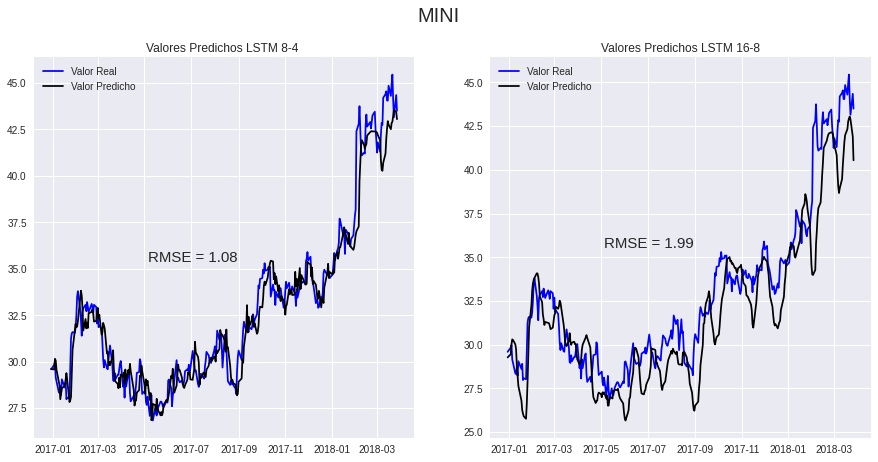

In [13]:
fig, axes = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la LSTM 10-5
axes[0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0].plot(index_time_t,predictedLSTM105, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos LSTM 8-4 ')
axes[0].annotate('RMSE = %.2f'% rmseLSTM105, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos LSTM 16-8')
axes[1].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)




plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [137]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedLSTM105
# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 160, -1.0: 149})


In [138]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      132773        0      0  44.35  42.4567  -1
Valor Final = 132772.56
Ganancia con margen = 32772.56


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [139]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      233283        0          2703      0  44.35  42.4567  -1
Valor Final = 113404.90
Ganancia con margen = 13404.90


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [140]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      174259        0          2019      0  44.35  42.4567  -1
Valor Final = 84716.80
Ganancia con margen = -15283.20


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  